# Parsing Inputs

In the chapter on [Grammars](Grammars.ipynb), we discussed how grammars can be
used to represent various languages. We also saw how grammars can be used to
generate strings of the corresponding language. Grammars can also perform the
reverse. That is, given a string, one can decompose the string into its
constituent parts that correspond to the parts of grammar used to generate it
– the _derivation tree_ of that string. These parts (and parts from other similar
strings) can later be recombined using the same grammar to produce new strings.

In this chapter, we use grammars to parse and decompose a given set of valid seed inputs into their corresponding derivation trees. This structural representation allows us to mutate, crossover, and recombine their parts in order to generate new valid, slightly changed inputs (i.e., fuzz)

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* An understanding of derivation trees from the [chapter on grammar fuzzer](GrammarFuzzer.ipynb)
  is also required.

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.Parser import <identifier>
```

and then make use of the following features.


This chapter introduces `Parser` classes, parsing a string into a _derivation tree_ as introduced in the [chapter on efficient grammar fuzzing](GrammarFuzzer.ipynb).  Two important parser classes are provided:

* [Parsing Expression Grammar parsers](#Parsing-Expression-Grammars) (`PEGParser`), which are very efficient, but limited to specific grammar structure; and
* [Earley parsers](#Parsing-Context-Free-Grammars) (`EarleyParser`), which accept any kind of context-free grammars.

Using any of these is fairly easy, though.  First, instantiate them with a grammar:

```python
>>> from Grammars import US_PHONE_GRAMMAR
>>> us_phone_parser = EarleyParser(US_PHONE_GRAMMAR)
```
Then, use the `parse()` method to retrieve a list of possible derivation trees:

```python
>>> trees = us_phone_parser.parse("(555)987-6543")
>>> tree = list(trees)[0]
>>> display_tree(tree)
```

![](PICS/Parser-synopsis-1.svg)

These derivation trees can then be used for test generation, notably for mutating and recombining existing inputs.



## Fuzzing a Simple Program

Here is a simple program that accepts a CSV file of vehicle details and processes this information.

In [1]:
def process_inventory(inventory):
    res = []
    for vehicle in inventory.split('\n'):
        ret = process_vehicle(vehicle)
        res.extend(ret)
    return '\n'.join(res)

The CSV file contains details of one vehicle per line. Each row is processed in `process_vehicle()`.

In [2]:
def process_vehicle(vehicle):
    year, kind, company, model, *_ = vehicle.split(',')
    if kind == 'van':
        return process_van(year, company, model)

    elif kind == 'car':
        return process_car(year, company, model)

    else:
        raise Exception('Invalid entry')

Depending on the kind of vehicle, the processing changes.

In [3]:
def process_van(year, company, model):
    res = ["We have a %s %s van from %s vintage." % (company, model, year)]
    iyear = int(year)
    if iyear > 2010:
        res.append("It is a recent model!")
    else:
        res.append("It is an old but reliable model!")
    return res

In [4]:
def process_car(year, company, model):
    res = ["We have a %s %s car from %s vintage." % (company, model, year)]
    iyear = int(year)
    if iyear > 2016:
        res.append("It is a recent model!")
    else:
        res.append("It is an old but reliable model!")
    return res

Here is a sample of inputs that the `process_inventory()` accepts.

In [5]:
mystring = """\
1997,van,Ford,E350
2000,car,Mercury,Cougar\
"""
print(process_inventory(mystring))

We have a Ford E350 van from 1997 vintage.
It is an old but reliable model!
We have a Mercury Cougar car from 2000 vintage.
It is an old but reliable model!


Let us try to fuzz this program. Given that the `process_inventory()` takes a CSV file, we can write a simple grammar for generating comma separated values, and generate the required CSV rows. For convenience, we fuzz `process_vehicle()` directly.

In [6]:
import string

In [7]:
CSV_GRAMMAR = {
    '<start>': ['<csvline>'],
    '<csvline>': ['<items>'],
    '<items>': ['<item>,<items>', '<item>'],
    '<item>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>': list(string.ascii_letters + string.digits + string.punctuation + ' \t\n')
}

 We need some infrastructure first for viewing the grammar.

In [8]:
import fuzzingbook_utils

In [9]:
from Grammars import EXPR_GRAMMAR, START_SYMBOL, RE_NONTERMINAL, is_valid_grammar, syntax_diagram
from Fuzzer import Fuzzer
from GrammarFuzzer import GrammarFuzzer, FasterGrammarFuzzer, display_tree, tree_to_string, dot_escape

from ExpectError import ExpectError
from Timer import Timer

start


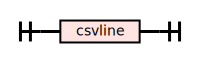

csvline


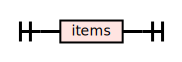

items


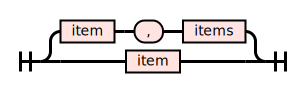

item


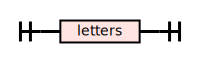

letters


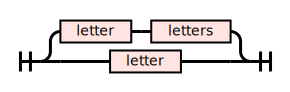

letter


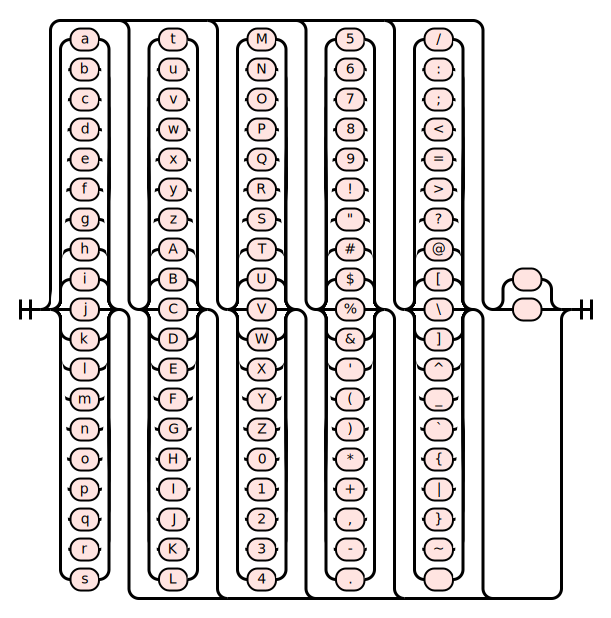

In [10]:
syntax_diagram(CSV_GRAMMAR)

We generate `1000` values, and evaluate the `process_vehicle()` with each.

In [11]:
gf = GrammarFuzzer(CSV_GRAMMAR, min_nonterminals=4)
trials = 1000
valid = []
time = 0
for i in range(trials):
    with Timer() as t:
        vehicle_info = gf.fuzz()
        try:
            process_vehicle(vehicle_info)
            valid.append(vehicle_info)
        except:
            pass
        time += t.elapsed_time()
print("%d valid strings, that is GrammarFuzzer generated %f%% valid entries from %d inputs" %
      (len(valid), len(valid) * 100.0 / trials, trials))
print("Total time of %f seconds" % time)

0 valid strings, that is GrammarFuzzer generated 0.000000% valid entries from 1000 inputs
Total time of 10.337474 seconds


This is obviously not working. But why?

In [12]:
gf = GrammarFuzzer(CSV_GRAMMAR, min_nonterminals=4)
trials = 10
valid = []
time = 0
for i in range(trials):
    vehicle_info = gf.fuzz()
    try:
        print(repr(vehicle_info), end="")
        process_vehicle(vehicle_info)
    except Exception as e:
        print("\t", e)
    else:
        print()

'9w9J\'/,LU<"l,|,Y,Zv)Amvx,c\n'	 Invalid entry
'(n8].H7,qolS'	 not enough values to unpack (expected at least 4, got 2)
'\nQoLWQ,jSa'	 not enough values to unpack (expected at least 4, got 2)
'K1,\n,RE,fq,%,,sT+aAb'	 Invalid entry
"m,d,,8j4'),-yQ,B7"	 Invalid entry
'g4,s1\t[}{.,M,<,\nzd,.am'	 Invalid entry
',Z[,z,c,#x1,gc.F'	 Invalid entry
'pWs,rT`,R'	 not enough values to unpack (expected at least 4, got 3)
'iN,br%,Q,R'	 Invalid entry
'ol,\nH<\tn,^#,=A'	 Invalid entry


None of the entries will get through unless the fuzzer can produce either `van` or `car`.
Indeed, the reason is that the grammar itself does not capture the complete information about the format. So here is another idea. We modify the `GrammarFuzzer` to know a bit about our format.

In [13]:
import copy

In [14]:
import random

In [15]:
class PooledGrammarFuzzer(GrammarFuzzer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._node_cache = {}

    def update_cache(self, key, values):
        self._node_cache[key] = values

    def expand_node_randomly(self, node):
        (symbol, children) = node
        assert children is None
        if symbol in self._node_cache:
            if random.randint(0, 1) == 1:
                return super().expand_node_randomly(node)
            return copy.deepcopy(random.choice(self._node_cache[symbol]))
        return super().expand_node_randomly(node)

Let us try again!

In [16]:
gf = PooledGrammarFuzzer(CSV_GRAMMAR, min_nonterminals=4)
gf.update_cache('<item>', [
    ('<item>', [('car', [])]),
    ('<item>', [('van', [])]),
])
trials = 10
valid = []
time = 0
for i in range(trials):
    vehicle_info = gf.fuzz()
    try:
        print(repr(vehicle_info), end="")
        process_vehicle(vehicle_info)
    except Exception as e:
        print("\t", e)
    else:
        print()

',h,van,|'	 Invalid entry
'M,w:K,car,car,van'	 Invalid entry
'J,?Y,van,van,car,J,~D+'	 Invalid entry
'S4,car,car,o'	 invalid literal for int() with base 10: 'S4'
'2*-,van'	 not enough values to unpack (expected at least 4, got 2)
'van,%,5,]'	 Invalid entry
'van,G3{y,j,h:'	 Invalid entry
'$0;o,M,car,car'	 Invalid entry
'2d,f,e'	 not enough values to unpack (expected at least 4, got 3)
'/~NE,car,car'	 not enough values to unpack (expected at least 4, got 3)


At least we are getting somewhere! It would be really nice if _we could incorporate what we know about the sample data in our fuzzer._ In fact, it would be nice if we could _extract_ the template and valid values from samples, and use them in our fuzzing. How do we do that?  The quick answer to this question is: Use a *parser*.  

## Using a Parser

Generally speaking, a _parser_ is the part of a a program that processes (structured) input.  The parsers we discuss in this chapter transform an input string into a _derivation tree_ (discussed in the [chapter on efficient grammar fuzzing](GrammarFuzzer.ipynb)).  From a user's perspective, all it takes to parse an input is two steps: 

1. Initialize the parser with a grammar, as in
```
parser = Parser(grammar)
```

2. Using the parser to retrieve a list of derivation trees:

```python
trees = parser.parse(input)
```

Once we have parsed a tree, we can use it just as the derivation trees produced from grammar fuzzing.

We discuss a number of such parsers, in particular
* [parsing expression grammar parsers](#Parsing-Expression-Grammars) (`PEGParser`), which are very efficient, but limited to specific grammar structure; and
* [Earley parsers](#Parsing-Context-Free-Grammars) (`EarleyParser`), which accept any kind of context-free grammars.

If you just want to _use_ parsers (say, because your main focus is testing), you can just stop here and move on [to the next chapter](LangFuzzer.ipynb), where we learn how to make use of parsed inputs to mutate and recombine them.  If you want to _understand_ how parsers work, though, this chapter is right for you.

## An Ad Hoc Parser

As we saw in the previous section, programmers often have to extract parts of data that obey certain rules. For example, for *CSV* files, each element in a row is separated by *commas*, and multiple raws are used to store the data.

To extract the information, we write an ad hoc parser `parse_csv()`.

In [17]:
def parse_csv(mystring):
    children = []
    tree = (START_SYMBOL, children)
    for i, line in enumerate(mystring.split('\n')):
        children.append(("record %d" % i, [(cell, [])
                                           for cell in line.split(',')]))
    return tree

We also change the default orientation of the graph to *left to right* rather than *top to bottom* for easier viewing using `lr_graph()`.

In [18]:
def lr_graph(dot):
    dot.attr('node', shape='plain')
    dot.graph_attr['rankdir'] = 'LR'

The `display_tree()` shows the structure of our CSV file after parsing.

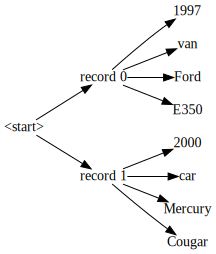

In [19]:
tree = parse_csv(mystring)
display_tree(tree, graph_attr=lr_graph)

This is of course simple. What if we encounter slightly more complexity? Again, another example from the Wikipedia.

In [20]:
mystring = '''\
1997,Ford,E350,"ac, abs, moon",3000.00\
'''
print(mystring)

1997,Ford,E350,"ac, abs, moon",3000.00


We define a new annotation method `highlight_node()` to mark the nodes that are interesting.

In [21]:
def highlight_node(predicate):
    def hl_node(dot, nid, symbol, ann):
        if predicate(dot, nid, symbol, ann):
            dot.node(repr(nid), dot_escape(symbol), fontcolor='red')
        else:
            dot.node(repr(nid), dot_escape(symbol))
    return hl_node

Using `highlight_node()` we can highlight particular nodes that we were wrongly parsed.

In [22]:
tree = parse_csv(mystring)
bad_nodes = {5, 6, 7, 12, 13, 20, 22, 23, 24, 25}

In [23]:
def hl_predicate(_d, nid, _s, _a): return nid in bad_nodes

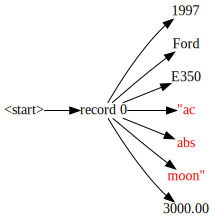

In [24]:
highlight_err_node = highlight_node(hl_predicate)
display_tree(tree, log=False, node_attr=highlight_err_node,
             graph_attr=lr_graph)

The marked nodes indicate where our parsing went wrong. We can of course extend our parser to understand quotes. First we define some of the helper functions `parse_quote()`, `find_comma()` and `comma_split()`

In [25]:
def parse_quote(string, i):
    v = string[i + 1:].find('"')
    return v + i + 1 if v >= 0 else -1

In [26]:
def find_comma(string, i):
    slen = len(string)
    while i < slen:
        if string[i] == '"':
            i = parse_quote(string, i)
            if i == -1:
                return -1
        if string[i] == ',':
            return i
        i += 1
    return -1

In [27]:
def comma_split(string):
    slen = len(string)
    i = 0
    while i < slen:
        c = find_comma(string, i)
        if c == -1:
            yield string[i:]
            return
        else:
            yield string[i:c]
        i = c + 1

We can update our `parse_csv()` procedure to use our advanced quote parser.

In [28]:
def parse_csv(mystring):
    children = []
    tree = (START_SYMBOL, children)
    for i, line in enumerate(mystring.split('\n')):
        children.append(("record %d" % i, [(cell, [])
                                           for cell in comma_split(line)]))
    return tree

Our new `parse_csv()` can now handle quotes correctly.

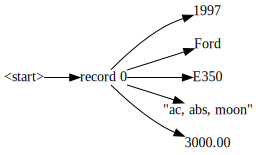

In [29]:
tree = parse_csv(mystring)
display_tree(tree, graph_attr=lr_graph)

That of course does not survive long:

In [30]:
mystring = '''\
1999,Chevy,"Venture \\"Extended Edition, Very Large\\"",,5000.00\
'''
print(mystring)

1999,Chevy,"Venture \"Extended Edition, Very Large\"",,5000.00


A few embedded quotes are sufficient to confuse our parser again.

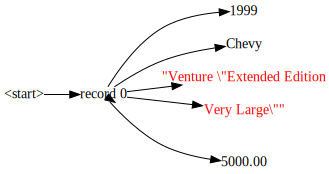

In [31]:
tree = parse_csv(mystring)
bad_nodes = {4, 5}
display_tree(tree, node_attr=highlight_err_node, graph_attr=lr_graph)

Here is another record from that CSV file:

In [32]:
mystring = '''\
1996,Jeep,Grand Cherokee,"MUST SELL!
air, moon roof, loaded",4799.00
'''
print(mystring)

1996,Jeep,Grand Cherokee,"MUST SELL!
air, moon roof, loaded",4799.00



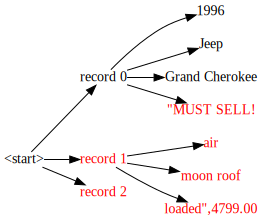

In [33]:
tree = parse_csv(mystring)
bad_nodes = {5, 6, 7, 8, 9, 10}
display_tree(tree, node_attr=highlight_err_node, graph_attr=lr_graph)

Fixing this would require modifying both inner `parse_quote()` and the outer `parse_csv()` procedures. We note that each of these features actually documented in the CSV [RFC 4180](https://tools.ietf.org/html/rfc4180)

Indeed, each additional improvement falls apart even with a little extra complexity. The problem becomes severe when one encounters recursive expressions. For example, JSON is a common alternative to CSV files for saving data. Similarly, one may have to parse data from an HTML table instead of a CSV file if one is getting the data from the web.

One might be tempted to fix it with a little more ad hoc parsing, with a bit of *regular expressions* thrown in. However, that is the [path to insanity](https://stackoverflow.com/a/1732454).

It is here that _formal parsers_ shine. The main idea is that, any given set of strings belong to a language, and these languages can be specified by their grammars (as we saw in the [chapter on grammars](Grammars.ipynb)). The great thing about grammars is that they can be _composed_. That is, one can introduce finer and finer details into an internal structure without affecting the external structure, and similarly, one can change the external structure without much impact on the internal structure. We briefly describe grammars in the next section.

## Grammars

A grammar, as you have read from the [chapter on grammars](Grammars.ipynb) is a set of _rules_ that explain how the start symbol can be expanded. Each rule has a name, also called a _nonterminal_, and a set of _alternative choices_ in how the nonterminal can be expanded.

In [34]:
A1_GRAMMAR = {
    "<start>": ["<expr>"],
    "<expr>": ["<expr>+<expr>", "<expr>-<expr>", "<integer>"],
    "<integer>": ["<digit><integer>", "<digit>"],
    "<digit>": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

start


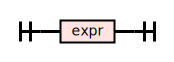

expr


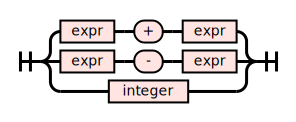

integer


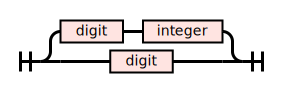

digit


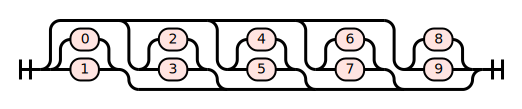

In [35]:
syntax_diagram(A1_GRAMMAR)

In the above expression, the rule `<expr> : [<expr>+<expr>,<expr>-<expr>,<integer>]` corresponds to how the nonterminal `<expr>` might be expanded.  The expression `<expr>+<expr>` corresponds to one of the alternative choices. We call this an _alternative_ expansion for the nonterminal `<expr>`. Finally, in an expression `<expr>+<expr>`, each of `<expr>`, `+`, and `<expr>` are _symbols_ in that expansion. A symbol could be either a nonterminal or a terminal symbol based on whether its expansion is available in the grammar.

Here is a string that represents an arithmetic expression that we would like to parse, which is specified by the grammar above:

In [36]:
mystring = '1+2'

The _derivation tree_ for our expression from this grammar is given by:

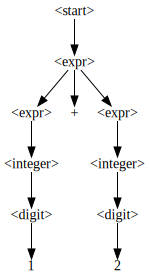

In [37]:
tree = ('<start>', [('<expr>',
                     [('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
                      ('+', []),
                      ('<expr>', [('<integer>', [('<digit>', [('2',
                                                               [])])])])])])
assert mystring == tree_to_string(tree)
display_tree(tree)

While a grammar can be used to specify a given language, there could be multiple
grammars that correspond to the same language. For example, here is another 
grammar to describe the same addition expression.

In [38]:
A2_GRAMMAR = {
    "<start>": ["<expr>"],
    "<expr>": ["<integer><expr_>"],
    "<expr_>": ["+<expr>", "-<expr>", ""],
    "<integer>": ["<digit><integer_>"],
    "<integer_>": ["<integer>", ""],
    "<digit>": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

start


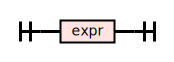

expr


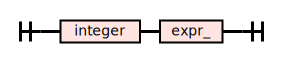

expr_


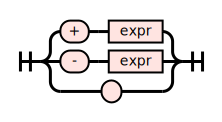

integer


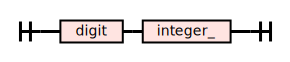

integer_


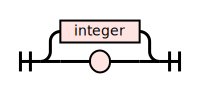

digit


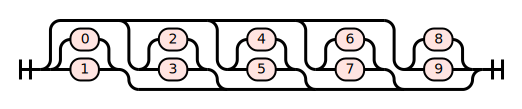

In [39]:
syntax_diagram(A2_GRAMMAR)

The corresponding derivation tree is given by:

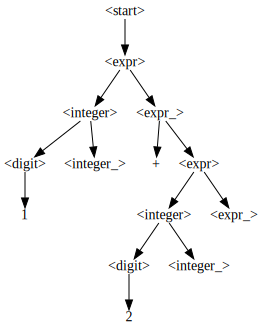

In [40]:
tree = ('<start>', [('<expr>', [('<integer>', [('<digit>', [('1', [])]),
                                               ('<integer_>', [])]),
                                ('<expr_>', [('+', []),
                                             ('<expr>',
                                              [('<integer>',
                                                [('<digit>', [('2', [])]),
                                                 ('<integer_>', [])]),
                                               ('<expr_>', [])])])])])
assert mystring == tree_to_string(tree)
display_tree(tree)

Indeed, there could be different classes of grammars that
describe the same language. For example, the first grammar `A1_GRAMMAR`
is a grammar that sports both _right_ and _left_ recursion, while the
second grammar `A2_GRAMMAR` does not have left recursion in the
nonterminals in any of its productions, but contains _epsilon_ productions.
(An epsilon production is a production that has empty string in its right
hand side.)

You would have noticed that we reuse the term `<expr>` in its own definition. Using the same nonterminal in its own definition is called *recursion*. There are two specific kinds of recursion one should be aware of in parsing, as we see in the next section.

#### Recursion

A grammar is _left recursive_ if any of its nonterminals are left recursive,
and a nonterminal is directly left-recursive if the left-most symbol of
any of its productions is itself.

In [41]:
LR_GRAMMAR = {
    '<start>': ['<A>'],
    '<A>': ['<A>a', ''],
}

start


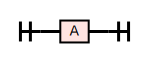

A


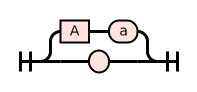

In [42]:
syntax_diagram(LR_GRAMMAR)

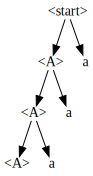

In [43]:
mystring = 'aaaaaa'
display_tree(
    ('<start>', (('<A>', (('<A>', (('<A>', []), ('a', []))), ('a', []))), ('a', []))))

A grammar is indirectly left-recursive if any
of the left-most symbols can be expanded using their definitions to
produce the nonterminal as the left-most symbol of the expansion. The left
recursion is called a _hidden-left-recursion_ if during the series of
expansions of  a nonterminal, one reaches a rule where the rule contains
the same nonterminal after a prefix of other symbols, and these symbols can
derive the empty string. For example, in `A1_GRAMMAR`, `<integer>` will be
considered hidden-left recursive if `<digit>` could derive an empty string.

Right recursive grammars are defined similarly.
Below is the derivation tree for the right recursive grammar that represents the same
language as that of `LR_GRAMMAR`.

In [44]:
RR_GRAMMAR = {
    '<start>': ['<A>'],
    '<A>': ['a<A>', ''],
}

start


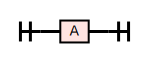

A


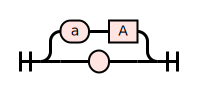

In [45]:
syntax_diagram(RR_GRAMMAR)

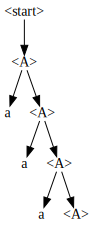

In [46]:
display_tree(('<start>', ((
    '<A>', (('a', []), ('<A>', (('a', []), ('<A>', (('a', []), ('<A>', []))))))),)))

#### Ambiguity

To complicate matters further, there could be
multiple derivation trees – also called _parses_ – corresponding to the
same string from the same grammar. For example, a string `1+2+3` can be parsed
in two ways as we see below using the `A1_GRAMMAR`

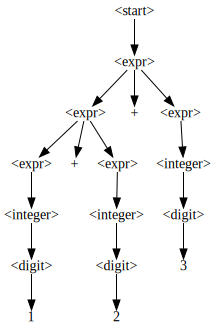

In [47]:
mystring = '1+2+3'
tree = ('<start>',
        [('<expr>',
          [('<expr>', [('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
                       ('+', []),
                       ('<expr>', [('<integer>',
                                    [('<digit>', [('2', [])])])])]), ('+', []),
           ('<expr>', [('<integer>', [('<digit>', [('3', [])])])])])])
assert mystring == tree_to_string(tree)
display_tree(tree)

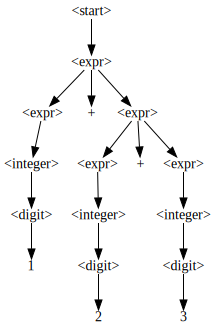

In [48]:
tree = ('<start>',
        [('<expr>', [('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
                     ('+', []),
                     ('<expr>',
                      [('<expr>', [('<integer>', [('<digit>', [('2', [])])])]),
                       ('+', []),
                       ('<expr>', [('<integer>', [('<digit>', [('3',
                                                                [])])])])])])])
assert tree_to_string(tree) == mystring
display_tree(tree)

There are many ways to resolve ambiguities. One approach taken by *Parsing Expression Grammars* explained in the next section is to specify a particular order of resolution, and choose the first one. Another approach is to simply return all possible derivation trees, which is the approach taken by *Earley parser* we develop later.

Next, we develop different parsers. To do that, we define a minimal interface for parsing that is obeyed by all parsers. There are two approaches to parsing a string using a grammar.

1. The traditional approach is to use a *lexer* (also called a *tokenizer* or a *scanner*) to first tokenize the incoming string, and feed the grammar one token at a time. The lexer is typically a smaller parser that accepts a *regular language*. The advantage of this approach is that the grammar used by the parser can eschew the details of tokenization. Further, one gets a shallow derivation tree at the end of the parsing which can be directly used for generating the *Abstract Syntax Tree*.
2. The second approach is to use a tree pruner after the complete parse. With this approach, one uses a grammar that incorporates complete details of the syntax. Next, the nodes corresponding to tokens are pruned and replaced with their corresponding strings as leaf nodes. The utility of this approach is that the parser is more powerful, and further there is no artificial distinction between *lexing* and *parsing*.

In this chapter, we use the second approach. This approach is implemented in the `prune_tree` method.

The *Parser* class we define below provides the minimal interface. The main methods that need to be implemented by the classes implementing this interface are `parse_prefix` and `parse`. The `parse_prefix` returns a tuple, which contains the index until which parsing was completed successfully, and the parse forest until that index. The method `parse` returns a list of derivation trees if the parse was successful.

In [49]:
class Parser(object):
    def __init__(self, grammar, **kwargs):
        self._grammar = grammar
        self._start_symbol = kwargs.get('start_symbol', START_SYMBOL)
        self.log = kwargs.get('log', False)
        self.coalesce_tokens = kwargs.get('coalesce', True)
        self.tokens = kwargs.get('tokens', set())

    def grammar(self):
        return self._grammar

    def start_symbol(self):
        return self._start_symbol

    def parse_prefix(self, text):
        """Return pair (cursor, forest) for longest prefix of text"""
        raise NotImplemented()

    def parse(self, text):
        cursor, forest = self.parse_prefix(text)
        if cursor < len(text):
            raise SyntaxError("at " + repr(text[cursor:]))
        return [self.prune_tree(tree) for tree in forest]

    def parse_on(self, text, start_symbol):
        old_start = self._start_symbol
        try:
            self._start_symbol = start_symbol
            yield from self.parse(text)
        finally:
            self._start_symbol = old_start

    def coalesce(self, children):
        last = ''
        new_lst = []
        for cn, cc in children:
            if cn not in self._grammar:
                last += cn
            else:
                if last:
                    new_lst.append((last, []))
                    last = ''
                new_lst.append((cn, cc))
        if last:
            new_lst.append((last, []))
        return new_lst

    def prune_tree(self, tree):
        name, children = tree
        if self.coalesce_tokens:
            children = self.coalesce(children)
        if name in self.tokens:
            return (name, [(tree_to_string(tree), [])])
        else:
            return (name, [self.prune_tree(c) for c in children])

## Parsing Expression Grammars

A _[Parsing Expression Grammar](http://bford.info/pub/lang/peg)_ (*PEG*) \cite{Ford2004} is a type of _recognition based formal grammar_ that specifies the sequence of steps to take to parse a given string.
A _parsing expression grammar_ is very similar to a _context-free grammar_ (*CFG*) such as the ones we saw in the [chapter on grammars](Grammars.ipynb). As in a CFG, a parsing expression grammar is represented by a set of nonterminals and corresponding alternatives representing how to match each. For example, here is a PEG that matches `a` or `b`.

In [50]:
PEG1 = {
    '<start>': ['a', 'b']
}

However, unlike the _CFG_, the alternatives represent *ordered choice*. That is, rather than choosing all rules that can potentially match, we stop at the first match that succeed. For example, the below _PEG_ can match `ab` but not `abc` unlike a _CFG_ which will match both. (We call the sequence of ordered choice expressions *choice expressions*  rather than alternatives to make the distinction from _CFG_ clear.)

In [51]:
PEG2 = {
    '<start>': ['ab', 'abc']
}

Each choice in a _choice expression_ represents a rule on how to satisfy that particular choice. The choice is a sequence of symbols (terminals and nonterminals) that are matched against a given text as in a _CFG_.

Beyond the syntax of grammar definitions we have seen so far, a _PEG_ can also contain a few additional elements. See the exercises at the end of the chapter for additional information.

The PEGs model the typical practice in handwritten recursive descent parsers, and hence it may be considered more intuitive to understand. We look at parsers for PEGs next.

### The Packrat Parser for Predicate Expression Grammars

Short of hand rolling a parser, _Packrat_ parsing is one of the simplest parsing techniques, and is one of the techniques for parsing PEGs.
The _Packrat_ parser is so named because it tries to cache all results from simpler problems in the hope that these solutions can be used to avoid re-computation later. We develop a minimal _Packrat_ parser next.

But before that, we need to implement a few supporting tools.

The  `EXPR_GRAMMAR` we import from the [chapter on grammars](Grammars.ipynb) is oriented towards generation. In particular, the production rules are stored as strings. We need to massage this representation a little to conform to a canonical representation where each token in a rule is represented separately. The `canonical` format uses separate tokens to represent each symbol in an expansion.

In [52]:
import re

In [53]:
def single_char_tokens(grammar):
    g_ = {}
    for key in grammar:
        rules_ = []
        for rule in grammar[key]:
            rule_ = []
            for token in rule:
                if token in grammar:
                    rule_.append(token)
                else:
                    rule_.extend(token)
            rules_.append(rule_)
        g_[key] = rules_
    return g_

In [54]:
def canonical(grammar):
    def split(expansion):
        if isinstance(expansion, tuple):
            expansion = expansion[0]

        return [token for token in re.split(
            RE_NONTERMINAL, expansion) if token]

    return {
        k: [split(expression) for expression in alternatives]
        for k, alternatives in grammar.items()
    }

In [55]:
CE_GRAMMAR = canonical(EXPR_GRAMMAR); CE_GRAMMAR

{'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

We also provide a convenience method for easier display of canonical grammars.

In [56]:
def recurse_grammar(grammar, key, order):
    rules = sorted(grammar[key])
    old_len = len(order)
    for rule in rules:
        for token in rule:
            if token not in grammar: continue
            if token not in order:
                order.append(token)
    new = order[old_len:]
    for ckey in new:
        recurse_grammar(grammar, ckey, order)

In [57]:
def show_grammar(grammar, start_symbol=START_SYMBOL):
    order = [start_symbol]
    recurse_grammar(grammar, start_symbol, order)
    return {k: sorted(grammar[k]) for k in order}

In [58]:
show_grammar(CE_GRAMMAR)

{'<start>': [['<expr>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<integer>': [['<digit>'], ['<digit>', '<integer>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

We provide a way to revert a canonical expression.

In [59]:
def non_canonical(grammar):
    new_grammar = {}
    for k in grammar:
        rules = grammar[k]
        new_rules = []
        for rule in rules:
            new_rules.append(''.join(rule))
        new_grammar[k] = new_rules
    return new_grammar

In [60]:
non_canonical(CE_GRAMMAR)

{'<start>': ['<expr>'],
 '<expr>': ['<term> + <expr>', '<term> - <expr>', '<term>'],
 '<term>': ['<factor> * <term>', '<factor> / <term>', '<factor>'],
 '<factor>': ['+<factor>',
  '-<factor>',
  '(<expr>)',
  '<integer>.<integer>',
  '<integer>'],
 '<integer>': ['<digit><integer>', '<digit>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

It is easier to work with the `canonical` representation during parsing. Hence, we update our parser class to store the `canonical` representation also.

In [61]:
class Parser(Parser):
    def __init__(self, grammar, **kwargs):
        self._start_symbol = kwargs.get('start_symbol', START_SYMBOL)
        self.log = kwargs.get('log', False)
        self.tokens = kwargs.get('tokens', set())
        self.coalesce_tokens = kwargs.get('coalesce', True)
        canonical_grammar = kwargs.get('canonical', False)
        if canonical_grammar:
            self.cgrammar = single_char_tokens(grammar)
            self._grammar = non_canonical(grammar)
        else:
            self._grammar = dict(grammar)
            self.cgrammar = single_char_tokens(canonical(grammar))
        # we do not require a single rule for the start symbol
        if len(grammar.get(self._start_symbol, [])) != 1:
            self.cgrammar['<>'] = [[self._start_symbol]]

We update the `prune_tree()` to account for the phony start symbol if it was insserted.

In [62]:
class Parser(Parser):
    def prune_tree(self, tree):
        name, children = tree
        if name == '<>':
            assert len(children) == 1
            return self.prune_tree(children[0])
        if self.coalesce_tokens:
            children = self.coalesce(children)
        if name in self.tokens:
            return (name, [(tree_to_string(tree), [])])
        else:
            return (name, [self.prune_tree(c) for c in children])

### The Parser

We derive from the `Parser` base class first, and we accept the text to be parsed in the `parse()` method, which in turn calls `unify_key()` with the `start_symbol`.

__Note.__ While our PEG parser can produce only a single unambiguous parse tree, other parsers can produce multiple parses for ambiguous grammars. Hence, we return a list of trees (in this case with a single element).

In [63]:
class PEGParser(Parser):
    def parse_prefix(self, text):
        cursor, tree = self.unify_key(self.start_symbol(), text, 0)
        return cursor, [tree]

#### Unify Key
The `unify_key()` algorithm is simple. If given a terminal symbol, it tries to match the symbol with the current position in the text. If the symbol and text match, it returns successfully with the new parse index `at`.

If on the other hand, it was given a nonterminal, it retrieves the choice expression corresponding to the key, and tries to match each choice *in order* using `unify_rule()`. If **any** of the rules succeed in being unified with the given text, the parse is considered a success, and we return with the new parse index returned by `unify_rule()`.

In [64]:
class PEGParser(PEGParser):
    def unify_key(self, key, text, at=0):
        if self.log:
            print("unify_key: %s with %s" % (repr(key), repr(text[at:])))
        if key not in self.cgrammar:
            if text[at:].startswith(key):
                return at + len(key), (key, [])
            else:
                return at, None
        for rule in self.cgrammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res is not None:
                return (to, (key, res))
        return 0, None

In [65]:
mystring = "1"
peg = PEGParser(EXPR_GRAMMAR, log=True)
peg.unify_key('1', mystring)

unify_key: '1' with '1'


(1, ('1', []))

In [66]:
mystring = "2"
peg.unify_key('1', mystring)

unify_key: '1' with '2'


(0, None)

#### Unify Rule

The `unify_rule()` method is similar. It retrieves the tokens corresponding to the rule that it needs to unify with the text, and calls `unify_key()` on them in sequence. If **all** tokens are successfully unified with the text, the parse is a success.

In [67]:
class PEGParser(PEGParser):
    def unify_rule(self, rule, text, at):
        if self.log:
            print('unify_rule: %s with %s' % (repr(rule), repr(text[at:])))
        results = []
        for token in rule:
            at, res = self.unify_key(token, text, at)
            if res is None:
                return at, None
            results.append(res)
        return at, results

In [68]:
mystring = "0"
peg = PEGParser(EXPR_GRAMMAR, log=True)
peg.unify_rule(peg.cgrammar['<digit>'][0], mystring, 0)

unify_rule: ['0'] with '0'
unify_key: '0' with '0'


(1, [('0', [])])

In [69]:
mystring = "12"
peg.unify_rule(peg.cgrammar['<integer>'][0], mystring, 0)

unify_rule: ['<digit>', '<integer>'] with '12'
unify_key: '<digit>' with '12'
unify_rule: ['0'] with '12'
unify_key: '0' with '12'
unify_rule: ['1'] with '12'
unify_key: '1' with '12'
unify_key: '<integer>' with '2'
unify_rule: ['<digit>', '<integer>'] with '2'
unify_key: '<digit>' with '2'
unify_rule: ['0'] with '2'
unify_key: '0' with '2'
unify_rule: ['1'] with '2'
unify_key: '1' with '2'
unify_rule: ['2'] with '2'
unify_key: '2' with '2'
unify_key: '<integer>' with ''
unify_rule: ['<digit>', '<integer>'] with ''
unify_key: '<digit>' with ''
unify_rule: ['0'] with ''
unify_key: '0' with ''
unify_rule: ['1'] with ''
unify_key: '1' with ''
unify_rule: ['2'] with ''
unify_key: '2' with ''
unify_rule: ['3'] with ''
unify_key: '3' with ''
unify_rule: ['4'] with ''
unify_key: '4' with ''
unify_rule: ['5'] with ''
unify_key: '5' with ''
unify_rule: ['6'] with ''
unify_key: '6' with ''
unify_rule: ['7'] with ''
unify_key: '7' with ''
unify_rule: ['8'] with ''
unify_key: '8' with ''
unify_rul

(2, [('<digit>', [('1', [])]), ('<integer>', [('<digit>', [('2', [])])])])

In [70]:
mystring = "1 + 2"
peg = PEGParser(EXPR_GRAMMAR, log=False)
peg.parse(mystring)

[('<start>',
  [('<expr>',
    [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]),
     (' + ', []),
     ('<expr>',
      [('<term>',
        [('<factor>', [('<integer>', [('<digit>', [('2', [])])])])])])])])]

The two methods are mutually recursive, and given that `unify_key()` tries each alternative until it succeeds, `unify_key` can be called multiple times with the same arguments. Hence, it is important to memoize the results of `unify_key`. Python provides a simple decorator `lru_cache` for memoizing any function call that has hashable arguments. We add that to our implementation so that repeated calls to `unify_key()` with the same argument get cached results.

This memoization gives the algorithm its name – _Packrat_.

In [71]:
from functools import lru_cache

In [72]:
class PEGParser(PEGParser):
    @lru_cache(maxsize=None)
    def unify_key(self, key, text, at=0):
        if key not in self.cgrammar:
            if text[at:].startswith(key):
                return at + len(key), (key, [])
            else:
                return at, None
        for rule in self.cgrammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res is not None:
                return (to, (key, res))
        return 0, None

We wrap initialization and calling of `PEGParser` in a method `parse()` already implemented in the `Parser` base class that accepts the text to be parsed along with the grammar.

Here are a few examples of our parser in action.

In [73]:
mystring = "1 + (2 * 3)"
peg = PEGParser(EXPR_GRAMMAR)
for tree in peg.parse(mystring):
    assert tree_to_string(tree) == mystring
    display_tree(tree)

In [74]:
mystring = "1 * (2 + 3.35)"
for tree in peg.parse(mystring):
    assert tree_to_string(tree) == mystring
    display_tree(tree)

One should be aware that while the grammar looks like a *CFG*, the language described by a *PEG* may be different. Indeed, only *LL(1)* grammars are guaranteed to represent the same language for both PEGs and other parsers. Behavior of PEGs for other classes of grammars could be surprising \cite{redziejowski2008}. 

## Parsing Context-Free Grammars

###  Problems with PEG
While _PEGs_ are simple at first sight, their behavior in some cases might be a bit unintuitive. For example, here is an example \cite{redziejowski2008}:

In [75]:
PEG_SURPRISE = {
    "<A>": ["a<A>a", "aa"]
}

When interpreted as a *CFG* and used as a string generator, it will produce strings of the form `aa, aaaa, aaaaaa` that is, it produces strings where the number of `a` is $ 2*n $ where $ n > 0 $.

In [76]:
strings = []
for e in range(4):
    f = GrammarFuzzer(PEG_SURPRISE, start_symbol='<A>')
    tree = ('<A>', None)
    for _ in range(e):
        tree = f.expand_tree_once(tree)
    tree = f.expand_tree_with_strategy(tree, f.expand_node_min_cost)
    strings.append(tree_to_string(tree))
    display_tree(tree)
strings

['aa', 'aaaa', 'aaaaaa', 'aaaaaaaa']

However, the _PEG_ parser can only recognize strings of the form $2^n$

In [77]:
peg = PEGParser(PEG_SURPRISE, start_symbol='<A>')
for s in strings:
    with ExpectError():
        for tree in peg.parse(s):
            display_tree(tree)
        print(s)

aa
aaaa
aaaaaaaa


Traceback (most recent call last):
  File "<ipython-input-77-dec55ebf796e>", line 4, in <module>
    for tree in peg.parse(s):
  File "<ipython-input-49-2be54e1115d5>", line 22, in parse
    raise SyntaxError("at " + repr(text[cursor:]))
  File "<string>", line None
SyntaxError: at 'aa' (expected)


This is not the only problem with _Parsing Expression Grammars_. While  *PEGs* are expressive and the *packrat* parser for parsing them is simple and intuitive, *PEGs* suffer from a major deficiency for our purposes. *PEGs* are oriented towards language recognition, and it is not clear how to translate an arbitrary *PEG* to a *CFG*. As we mentioned earlier, a naive re-interpretation of a *PEG* as a *CFG* does not work very well. Further, it is not clear what is the exact relation between the class of languages represented by *PEG* and the class of languages represented by *CFG*. Since our primary focus is *fuzzing* – that is _generation_ of strings – , we next look at _parsers that can accept context-free grammars_.

The general idea of *CFG* parser is the following: Peek at the input text for the allowed number of characters, and use these, and our parser state to determine which rules can be applied to complete parsing. We next look at a typical *CFG* parsing algorithm, the Earley Parser.

### The Earley Parser

The Earley parser is a general parser that is able to parse any arbitrary *CFG*. It was invented by Jay Earley \cite{Earley1970} for use in computational linguistics. While its computational complexity is $O(n^3)$ for parsing strings with arbitrary grammars, it can parse strings with unambiguous grammars in $O(n^2)$ time, and all *[LR(k)](https://en.wikipedia.org/wiki/LR_parser)* grammars in linear time ($O(n)$ \cite{Leo1991}). Further improvements – notably handling epsilon rules – were invented by Aycock et al. \cite{Aycock2002}.

Note that one restriction of our implementation is that the start symbol can have only one alternative in its alternative expressions. This is not a restriction in practice because any grammar with multiple alternatives for its start symbol can be extended with a new start symbol that has the original start symbol as its only choice. That is, given a grammar as below,

```
grammar = {
    '<start>': ['<A>', '<B>'],
    ...
}
```
one may rewrite it as below to conform to the *single-alternative* rule.
```
grammar = {
    '<start>': ['<start_>'],
    '<start_>': ['<A>', '<B>'],
    ...
}
```

We first implement a simpler parser that is a parser for nearly all *CFGs*, but not quite. In particular, our parser does not understand _epsilon rules_ – rules that derive empty string. We show later how the parser can be extended to handle these.

We use the following grammar in our examples below.

In [78]:
SAMPLE_GRAMMAR = {
    '<start>': ['<A><B>'],
    '<A>': ['a<B>c', 'a<A>'],
    '<B>': ['b<C>', '<D>'],
    '<C>': ['c'],
    '<D>': ['d']
}
C_SAMPLE_GRAMMAR = canonical(SAMPLE_GRAMMAR)

start


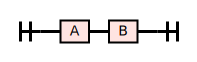

A


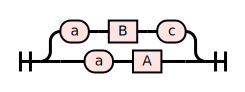

B


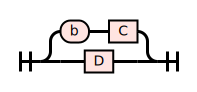

C


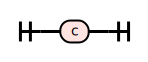

D


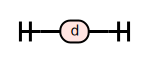

In [79]:
syntax_diagram(SAMPLE_GRAMMAR)

The basic idea of Earley parsing is the following:

* Start with the alternative expressions corresponding to the START_SYMBOL. These represent the possible ways to parse the string from a high level. Essentially each expression represents a parsing path. Queue each expression in our set of possible parses of the string. The parsed index of an expression is the part of expression that has already been recognized. In the beginning of parse, the parsed index of all expressions is at the beginning. Further, each letter gets a queue of expressions that recognizes that letter at that point in our parse.
* Examine our queue of possible parses and check if any of them start with a nonterminal. If it does, then that nonterminal needs to be recognized from the input before the given rule can be parsed. Hence, add the alternative expressions corresponding to the nonterminal to the queue. Do this recursively.
* At this point, we are ready to advance. Examine the current letter in the input, and select all expressions that have that particular letter at the parsed index. These expressions can now advance one step. Advance these selected expressions by incrementing their parsed index and add them to the queue of expressions in line for recognizing the next input letter.
* If while doing these things, we find that any of the expressions have finished parsing, we fetch its corresponding nonterminal, and advance all expressions that have that nonterminal at their parsed index.
* Continue this procedure recursively until all expressions that we have queued for the current letter have been processed. Then start processing the queue for the next letter.

We explain each step in detail with examples in the coming sections.

The parser uses dynamic programming to generate a table containing a _forest of possible parses_ at each letter index – the table contains as many columns as there are letters in the input, and each column contains different parsing rules at various stages of the parse.

For example, given an input `adcd`, the Column 0 would contain the following:
```
<start> : ● <A> <B>
```
which is the starting rule that indicates that we are currently parsing the rule `<start>`, and the parsing state is just before identifying the symbol `<A>`. It would also contain the following which are two alternative paths it could take to complete the parsing.

```
<A> : ● a <B> c
<A> : ● a <A>
```

Column 1 would contain the following, which represents the possible completion after reading `a`.
```
<A> : a ● <B> c
<A> : a ● <A>
<B> : ● b <C>
<B> : ● <D>
<A> : ● a <B> c
<A> : ● a <A>
<D> : ● d
```

Column 2 would contain the following after reading `d`
```
<D> : d ●
<B> : <D> ●
<A> : a <B> ● c
```

Similarly, Column 3 would contain the following after reading `c`
```
<A> : a <B> c ●
<start> : <A> ● <B>
<B> : ● b <C>
<B> : ● <D>
<D> : ● d
```

Finally, Column 4 would contain the following after reading `d`, with the `●` at the end of the `<start>` rule indicating that the parse was successful.
```
<D> : d ●
<B> : <D> ●
<start> : <A> <B> ●
```

As you can see from above, we are essentially filling a table (a table is also called a **chart**) of entries based on each letter we read, and the grammar rules that can be applied. This chart gives the parser its other name -- Chart parsing.

### Columns

We define the `Column` first. The `Column` is initialized by its own `index` in the input string, and the `letter` at that index. Internally, we also keep track of the states that are added to the column as the parsing progresses.

In [80]:
class Column(object):
    def __init__(self, index, letter):
        self.index, self.letter = index, letter
        self.states, self._unique = [], {}

    def __str__(self):
        return "%s chart[%d]\n%s" % (self.letter, self.index, "\n".join(
            str(state) for state in self.states if state.finished()))

The `Column` only stores unique `states`. Hence, when a new `state` is `added` to our `Column`, we check whether it is already known.

In [81]:
class Column(Column):
    def add(self, state):
        if state in self._unique:
            return self._unique[state]
        self._unique[state] = state
        self.states.append(state)
        state.e_col = self
        return self._unique[state]

### Items

An item represents a _parse in progress for a specific rule._ Hence the item contains the name of the nonterminal, and the corresponding alternative expression (`expr`) which together form the rule, and the current position of parsing in this expression -- `dot`.


**Note.** If you are familiar with [LR parsing](https://en.wikipedia.org/wiki/LR_parser), you will notice that an item is simply an `LR0` item.

In [82]:
class Item(object):
    def __init__(self, name, expr, dot):
        self.name, self.expr, self.dot = name, expr, dot

We also provide a few convenience methods. The method `finished()` checks if the `dot` has moved beyond the last element in `expr`. The method `advance()` produces a new `Item` with the `dot` advanced one token, and represents an advance of the parsing.  The method `at_dot()` returns the current symbol being parsed.

In [83]:
class Item(Item):
    def finished(self):
        return self.dot >= len(self.expr)

    def advance(self):
        return Item(self.name, self.expr, self.dot + 1)

    def at_dot(self):
        return self.expr[self.dot] if self.dot < len(self.expr) else None

Here is how an item could be used. We first define our item

In [84]:
item_name = '<B>'
item_expr = C_SAMPLE_GRAMMAR[item_name][1]
an_item = Item(item_name, tuple(item_expr), 0)

To determine where the status of parsing, we use `at_dot()`

In [85]:
an_item.at_dot()

'<D>'

That is, the next symbol to be parsed is `<D>`

If we advance the item, we get another item that represents the finished parsing rule `<B>`.

In [86]:
another_item = an_item.advance()

In [87]:
another_item.finished()

True

### States

For `Earley` parsing, the state of the parsing is simply one `Item` along with some meta information such as the starting `s_col`  and ending column `e_col` for each state. Hence we inherit from `Item` to create a `State`.
Since we are interested in comparing states, we define `hash()` and `eq()` with the corresponding methods.

In [88]:
class State(Item):
    def __init__(self, name, expr, dot, s_col, e_col=None):
        super().__init__(name, expr, dot)
        self.s_col, self.e_col = s_col, e_col

    def __str__(self):
        def idx(var):
            return var.index if var else -1

        return self.name + ':= ' + ' '.join([
            str(p)
            for p in [*self.expr[:self.dot], '|', *self.expr[self.dot:]]
        ]) + "(%d,%d)" % (idx(self.s_col), idx(self.e_col))

    def copy(self):
        return State(self.name, self.expr, self.dot, self.s_col, self.e_col)

    def _t(self):
        return (self.name, self.expr, self.dot, self.s_col.index)

    def __hash__(self):
        return hash(self._t())

    def __eq__(self, other):
        return self._t() == other._t()

    def advance(self):
        return State(self.name, self.expr, self.dot + 1, self.s_col)

The usage of `State` is similar to that of `Item`. The only difference is that it is used along with the `Column` to track the parsing state. For example, we initialize the first column as follows:

In [89]:
col_0 = Column(0, None)
item_expr = tuple(*C_SAMPLE_GRAMMAR[START_SYMBOL])
start_state = State(START_SYMBOL, item_expr, 0, col_0)
col_0.add(start_state)
start_state.at_dot()

'<A>'

The first column is then updated by using `add()` method of `Column`

In [90]:
sym = start_state.at_dot()
for alt in C_SAMPLE_GRAMMAR[sym]:
    col_0.add(State(sym, tuple(alt), 0, col_0))
for s in col_0.states:
    print(s)

<start>:= | <A> <B>(0,0)
<A>:= | a <B> c(0,0)
<A>:= | a <A>(0,0)


### The Parsing Algorithm

The _Earley_ algorithm starts by initializing the chart with columns (as many as there are letters in the input). We also seed the first column with a state representing the expression corresponding to the start symbol. In our case, the state corresponds to the start symbol with the `dot` at `0` is represented as below. The `●` symbol represents the parsing status. In this case, we have not parsed anything.
```
<start>: ● <A> <B>
```
We pass this partial chart to a method for filling the rest of the parse chart.

Before starting to parse, we seed the chart with the state representing the ongoing parse of the start symbol.

In [91]:
class EarleyParser(Parser):
    def chart_parse(self, words, start):
        alt = tuple(*self.cgrammar[start])
        chart = [Column(i, tok) for i, tok in enumerate([None, *words])]
        chart[0].add(State(start, alt, 0, chart[0]))
        return self.fill_chart(chart)

The main parsing loop in `fill_chart()` has three fundamental operations. `predict()`, `scan()`, and `complete()`. We discuss `predict` next.

### Predicting States

We have already seeded `chart[0]` with a state `[<A>,<B>]` with `dot` at `0`. Next, given that `<A>` is a nonterminal, we `predict` the possible parse continuations of this state. That is, it could be either `a <B> c` or `A <A>`.

The general idea of `predict()` is as follows: Say you have a state with name `<A>` from the above grammar, and expression containing `[a,<B>,c]`. Imagine that you have seen `a` already, which means that the `dot` will be on `<B>`. Below, is a representation of our parse status. The left hand side of ● represents the portion already parsed (`a`), and the right hand side represents the portion yet to be parsed (`<B> c`).

```
<A>: a  ●  <B> c
```

To recognize `<B>`, we look at the definition of `<B>`, which has different alternative expressions. The `predict()` step adds each of these alternatives to the set of states, with `dot` at `0`.

```
<A>: a ● <B> c
<B>: ● b c
<B>: ● <D>
```

In essence, the `predict()` method, when called with the current nonterminal, fetches the alternative expressions corresponding to this nonterminal, and adds these as predicted _child_ states to the _current_ column.

In [92]:
class EarleyParser(EarleyParser):
    def predict(self, col, sym, state):
        for alt in self.cgrammar[sym]:
            col.add(State(sym, tuple(alt), 0, col))

To see how to use `predict`, we first construct the 0th column as before, and we assign the constructed column to an instance of the EarleyParser.

In [93]:
col_0 = Column(0, None)
col_0.add(start_state)
ep = EarleyParser(SAMPLE_GRAMMAR)
ep.chart = [col_0]

It should contain a single state -- `<start> at 0`

In [94]:
for s in ep.chart[0].states:
    print(s)

<start>:= | <A> <B>(0,0)


We apply predict to fill out the 0th column, and the column should contain the possible parse paths.

In [95]:
ep.predict(col_0, '<A>', s)
for s in ep.chart[0].states:
    print(s)

<start>:= | <A> <B>(0,0)
<A>:= | a <B> c(0,0)
<A>:= | a <A>(0,0)


### Scanning Tokens

What if rather than a nonterminal, the state contained a terminal symbol such as a letter? In that case, we are ready to make some progress. For example, consider the second state:
```
<B>: ● b c
```
We `scan` the next column's letter. Say the next token is `b`.
If the letter matches what we have, then create a new state by advancing the current state by one letter.

```
<B>: b ● c
```
This new state is added to the next column (i.e the column that has the matched letter).

In [96]:
class EarleyParser(EarleyParser):
    def scan(self, col, state, letter):
        if letter == col.letter:
            col.add(state.advance())

As before, we construct the partial parse first, this time adding a new column so that we can observe the effects of `scan()`

In [97]:
ep = EarleyParser(SAMPLE_GRAMMAR)
col_1 = Column(1, 'a')
ep.chart = [col_0, col_1]

In [98]:
new_state = ep.chart[0].states[1]
print(new_state)

<A>:= | a <B> c(0,0)


In [99]:
ep.scan(col_1, new_state, 'a')
for s in ep.chart[1].states:
    print(s)

<A>:= a | <B> c(0,1)


### Completing Processing

When we advance, what if we actually `complete()` the processing of the current rule? If so, we want to update not just this state, but also all the _parent_ states from which this state was derived.
For example, say we have states as below.
```
<A>: a ● <B> c
<B>: b c ● 
```
The state `<B>: b c ●` is now complete. So, we need to advance `<A>: a ● <B> c` one step forward.

How do we determine the parent states? Note from `predict` that we added the predicted child states to the _same_ column as that of the inspected state. Hence, we look at the starting column of the current state, with the same symbol `at_dot` as that of the name of the completed state.

For each such parent found, we advance that parent (because we have just finished parsing that non terminal for their `at_dot`) and add the new states to the current column.

In [100]:
class EarleyParser(EarleyParser):
    def complete(self, col, state):
        return self.earley_complete(col, state)

    def earley_complete(self, col, state):
        parent_states = [
            st for st in state.s_col.states if st.at_dot() == state.name
        ]
        for st in parent_states:
            col.add(st.advance())

Here is an example of completed processing. First we complete the Column 0

In [101]:
ep = EarleyParser(SAMPLE_GRAMMAR)
col_1 = Column(1, 'a')
col_2 = Column(2, 'd')
ep.chart = [col_0, col_1, col_2]
ep.predict(col_0, '<A>', s)
for s in ep.chart[0].states:
    print(s)

<start>:= | <A> <B>(0,0)
<A>:= | a <B> c(0,0)
<A>:= | a <A>(0,0)


Then we use `scan()` to populate Column 1

In [102]:
for state in ep.chart[0].states:
    if state.at_dot() not in SAMPLE_GRAMMAR:
        ep.scan(col_1, state, 'a')
for s in ep.chart[1].states:
    print(s)

<A>:= a | <B> c(0,1)
<A>:= a | <A>(0,1)


In [103]:
for state in ep.chart[1].states:
    if state.at_dot() in SAMPLE_GRAMMAR:
        ep.predict(col_1, state.at_dot(), state)
for s in ep.chart[1].states:
    print(s)

<A>:= a | <B> c(0,1)
<A>:= a | <A>(0,1)
<B>:= | b <C>(1,1)
<B>:= | <D>(1,1)
<A>:= | a <B> c(1,1)
<A>:= | a <A>(1,1)
<D>:= | d(1,1)


Then we use `scan()` again to populate Column 2

In [104]:
for state in ep.chart[1].states:
    if state.at_dot() not in SAMPLE_GRAMMAR:
        ep.scan(col_2, state, state.at_dot())

for s in ep.chart[2].states:
    print(s)

<D>:= d |(1,2)


Now, we can use `complete()`:

In [105]:
for state in ep.chart[2].states:
    if state.finished():
        ep.complete(col_2, state)

for s in ep.chart[2].states:
    print(s)

<D>:= d |(1,2)
<B>:= <D> |(1,2)
<A>:= a <B> | c(0,2)


### Filling the Chart

The main driving loop in `fill_chart()` essentially calls these operations in order. We loop over each column in order.
* For each column, fetch one state in the column at a time, and check if the state is `finished`. 
    * If it is, then we `complete()` all the parent states depending on this state. 
* If the state was not finished, we check to see if the state's current symbol `at_dot` is a nonterminal. 
    * If it is a nonterminal, we `predict()` possible continuations, and update the current column with these states. 
    * If it was not, we `scan()` the next column and advance the current state if it matches the next letter.

In [106]:
class EarleyParser(EarleyParser):
    def fill_chart(self, chart):
        for i, col in enumerate(chart):
            for state in col.states:
                if state.finished():
                    self.complete(col, state)
                else:
                    sym = state.at_dot()
                    if sym in self.cgrammar:
                        self.predict(col, sym, state)
                    else:
                        if i + 1 >= len(chart):
                            continue
                        self.scan(chart[i + 1], state, sym)
            if self.log:
                print(col, '\n')
        return chart

We now can recognize a given string as belonging to a language represented by a grammar.

In [107]:
ep = EarleyParser(SAMPLE_GRAMMAR, log=True)
columns = ep.chart_parse('adcd', START_SYMBOL)

None chart[0]
 

a chart[1]
 

d chart[2]
<D>:= d |(1,2)
<B>:= <D> |(1,2) 

c chart[3]
<A>:= a <B> c |(0,3) 

d chart[4]
<D>:= d |(3,4)
<B>:= <D> |(3,4)
<start>:= <A> <B> |(0,4) 



The chart we printed above only shows completed entries at each index. The parenthesized expression indicates the column just before the first character was recognized, and the ending column.

Notice how the `<start>` nonterminal shows fully parsed status.

In [108]:
last_col = columns[-1]
for s in last_col.states:
    if s.name == '<start>':
        print(s)

<start>:= <A> <B> |(0,4)


Since `chart_parse()` returns the completed table, we now need to extract the derivation trees.

### The Parse Method

For determining how far we have managed to parse, we simply look for the last index from `chart_parse()` where the `start_symbol` was found.

In [109]:
class EarleyParser(EarleyParser):
    def parse_prefix(self, text):
        self.table = self.chart_parse(text, self.start_symbol())
        for col in reversed(self.table):
            states = [
                st for st in col.states if st.name == self.start_symbol()
            ]
            if states:
                return col.index, states
        return -1, []

Here is the `parse_prefix()` in action.

In [110]:
ep = EarleyParser(SAMPLE_GRAMMAR)
cursor, last_states = ep.parse_prefix('adcd')
print(cursor, [str(s) for s in last_states])

4 ['<start>:= <A> <B> |(0,4)']


The following is adapted from the excellent reference on Earley parsing by [Loup Vaillant](http://loup-vaillant.fr/tutorials/earley-parsing/).


Our `parse()` method is as follows. It depends on two methods `parse_forest()` and `extract_trees()` that will be defined next.

In [111]:
class EarleyParser(EarleyParser):
    def parse(self, text):
        cursor, states = self.parse_prefix(text)
        start = next((s for s in states if s.finished()), None)

        if cursor < len(text) or not start:
            raise SyntaxError("at " + repr(text[cursor:]))

        forest = self.parse_forest(self.table, start)
        for tree in self.extract_trees(forest):
            yield self.prune_tree(tree)

### Parsing Paths

The `parse_paths()` method tries to unify the given expression in `named_expr` with the parsed string. For that, it extracts the last symbol in `named_expr` and checks if it is a terminal symbol. If it is, then it checks the chart at `til` to see if the letter corresponding to the position matches the terminal symbol. If it does, extend our start index by the length of the symbol.

If the symbol was a nonterminal symbol, then we retrieve the parsed states at the current end column index (`til`) that correspond to the nonterminal symbol, and collect the start index. These are the end column indexes for the remaining expression.

Given our list of start indexes, we obtain the parse paths from the remaining expression. If we can obtain any, then we return the parse paths. If not, we return an empty list.

In [112]:
class EarleyParser(EarleyParser):
    def parse_paths(self, named_expr, chart, frm, til):
        def paths(state, start, k, e):
            if not e:
                return [[(state, k)]] if start == frm else []
            else:
                return [[(state, k)] + r
                        for r in self.parse_paths(e, chart, frm, start)]

        *expr, var = named_expr
        starts = None
        if var not in self.cgrammar:
            starts = ([(var, til - len(var),
                        't')] if til > 0 and chart[til].letter == var else [])
        else:
            starts = [(s, s.s_col.index, 'n') for s in chart[til].states
                      if s.finished() and s.name == var]

        return [p for s, start, k in starts for p in paths(s, start, k, expr)]

Here is the `parse_paths()` in action

In [113]:
print(SAMPLE_GRAMMAR['<start>'])
ep = EarleyParser(SAMPLE_GRAMMAR)
completed_start = last_states[0]
paths = ep.parse_paths(completed_start.expr, columns, 0, 4)
for path in paths:
    print([list(str(s_) for s_ in s) for s in path])

['<A><B>']
[['<B>:= <D> |(3,4)', 'n'], ['<A>:= a <B> c |(0,3)', 'n']]


That is, the parse path for `<start>` given the input `adcd` included recognizing the expression `<A><B>`. This was recognized by the two states: `<A>` from input(0) to input(2) which further involved recognizing the rule `a<B>c`, and the next state `<B>` from input(3) which involved recognizing the rule `<D>`.

### Parsing Forests

The `parse_forest()` method takes the state which represents the completed parse, and determines the possible ways that its expressions corresponded to the parsed expression. For example, say we are parsing `1+2+3`, and the state has `[<expr>,+,<expr>]` in `expr`. It could have been parsed as either `[{<expr>:1+2},+,{<expr>:3}]` or `[{<expr>:1},+,{<expr>:2+3}]`.

In [114]:
class EarleyParser(EarleyParser):
    def forest(self, s, kind, chart):
        return self.parse_forest(chart, s) if kind == 'n' else (s, [])

    def parse_forest(self, chart, state):
        pathexprs = self.parse_paths(state.expr, chart, state.s_col.index,
                                     state.e_col.index) if state.expr else []
        return state.name, [[(v, k, chart) for v, k in reversed(pathexpr)]
                            for pathexpr in pathexprs]

In [115]:
ep = EarleyParser(SAMPLE_GRAMMAR)
result = ep.parse_forest(columns, last_states[0])
result

('<start>',
 [[(<__main__.State at 0x7f933bf39940>,
    'n',
     <__main__.Column at 0x7f933bf394e0>]),
   (<__main__.State at 0x7f933bf39ef0>,
    'n',
     <__main__.Column at 0x7f933bf394e0>])]])

### Extracting Trees

What we have from `parse_forest()` is a forest of trees. We need to extract a single tree from that forest. That is accomplished as follows.

(For now, we return the first available derivation tree. To do that, we need to extract the parse forest from the state corresponding to `start`.)

In [116]:
class EarleyParser(EarleyParser):
    def extract_a_tree(self, forest_node):
        name, paths = forest_node
        if not paths:
            return (name, [])
        return (name, [self.extract_a_tree(self.forest(*p)) for p in paths[0]])

    def extract_trees(self, forest):
        yield self.extract_a_tree(forest)

We now verify that our parser can parse a given expression.

In [117]:
A3_GRAMMAR = {
    "<start>": ["<bexpr>"],
    "<bexpr>": [
        "<aexpr><gt><aexpr>", "<aexpr><lt><aexpr>", "<aexpr>=<aexpr>",
        "<bexpr>=<bexpr>", "<bexpr>&<bexpr>", "<bexpr>|<bexpr>", "(<bexrp>)"
    ],
    "<aexpr>":
    ["<aexpr>+<aexpr>", "<aexpr>-<aexpr>", "(<aexpr>)", "<integer>"],
    "<integer>": ["<digit><integer>", "<digit>"],
    "<digit>": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    "<lt>": ['<'],
    "<gt>": ['>']
}

start


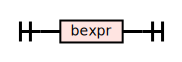

bexpr


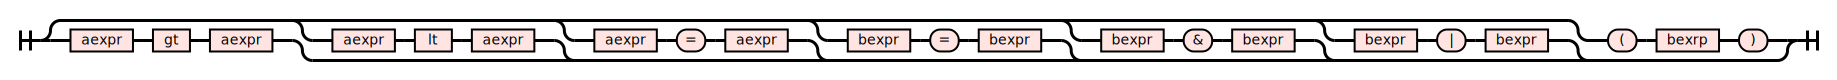

aexpr


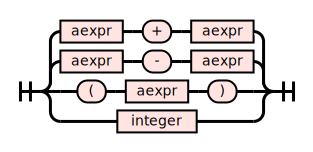

integer


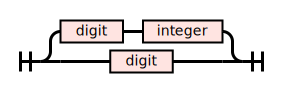

digit


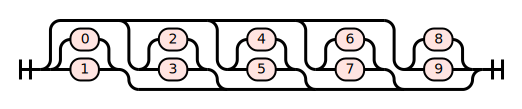

lt


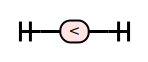

gt


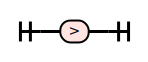

In [118]:
syntax_diagram(A3_GRAMMAR)

In [119]:
mystring = '(1+24)=33'
parser = EarleyParser(A3_GRAMMAR)
for tree in parser.parse(mystring):
    assert tree_to_string(tree) == mystring
    display_tree(tree)

We now have a complete parser that can parse almost arbitrary *CFG*. There remains a small corner to fix -- the case of epsilon rules as we will see later.

### Ambiguous Parsing

Ambiguous grammars are grammars that can produce multiple derivation trees for some given string. For example, the `A3_GRAMMAR` can parse `1+2+3` in two different ways – `[1+2]+3` and `1+[2+3]`.

Extracting a single tree might be reasonable for unambiguous parses. However, what if the given grammar produces ambiguity when given a string? We need to extract all derivation trees in that case. We enhance our `extract_trees()` method to extract multiple derivation trees.

In [120]:
import itertools as I

In [121]:
class EarleyParser(EarleyParser):
    def extract_trees(self, forest_node):
        name, paths = forest_node
        if not paths:
            yield (name, [])
        results = []
        for path in paths:
            ptrees = [self.extract_trees(self.forest(*p)) for p in path]
            for p in I.product(*ptrees):
                yield (name, p) 

As before, we verify that everything works.

In [122]:
mystring = '1+2'
parser = EarleyParser(A1_GRAMMAR)
for tree in parser.parse(mystring):
    assert mystring == tree_to_string(tree)
    display_tree(tree)

One can also use a `GrammarFuzzer` to verify that everything works.

In [123]:
gf = GrammarFuzzer(A1_GRAMMAR)
for i in range(5):
    s = gf.fuzz()
    print(i, s)
    for tree in parser.parse(s):
        assert tree_to_string(tree) == s

0 045+3+2-9+7-7-5-1-449
1 0+9+5-2+1-8+4-3+7+2
2 76413
3 9339
4 62


### The Aycock Epsilon Fix

While parsing, one often requires to know whether a given nonterminal can derive an empty string. For example, in the following grammar A can derive an empty string, while B can't. The nonterminals that can derive an empty string are called _nullable_ nonterminals. For example, in the below grammar `E_GRAMMAR_1`,  `<A>` is _nullable_, and since `<A>` is one of the alternatives of `<start>`, `<start>` is also _nullable_. But `<B>` is not _nullable_.

In [124]:
E_GRAMMAR_1 = {
    '<start>': ['<A>', '<B>'],
    '<A>': ['a', ''],
    '<B>': ['b']
}

One of the problems with the original Earley implementation is that it does not handle rules that can derive empty strings very well. For example, the given grammar should match `a`

In [125]:
EPSILON = ''
E_GRAMMAR = {
    '<start>': ['<S>'],
    '<S>': ['<A><A><A><A>'],
    '<A>': ['a', '<E>'],
    '<E>': [EPSILON]
}

start


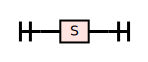

S


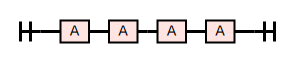

A


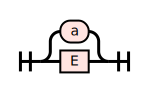

E


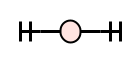

In [126]:
syntax_diagram(E_GRAMMAR)

In [127]:
mystring = 'a'
parser = EarleyParser(E_GRAMMAR)
with ExpectError():
    trees = parser.parse(mystring)

Aycock et al.\cite{Aycock2002} suggests a simple fix. Their idea is to pre-compute the `nullable` set and use it to advance the `nullable` states. However, before we do that, we need to compute the `nullable` set. The `nullable` set consists of all nonterminals that can derive an empty string.

Computing the `nullable` set requires expanding each production rule in the grammar iteratively and inspecting whether a given rule can derive the empty string. Each iteration needs to take into account new terminals that have been found to be `nullable`. The procedure stops when we obtain a stable result. This procedure can be abstracted into a more general method `fixpoint`.

#### Fixpoint

A `fixpoint` of a function is an element in the function's domain such that it is mapped to itself. For example, 1 is a `fixpoint` of square root because `squareroot(1) == 1`.

(We use `str` rather than `hash` to check for equality in `fixpoint` because the data structure `set`, which we would like to use as an argument has a good string representation but is not hashable).

In [128]:
def fixpoint(f):
    def helper(arg):
        while True:
            sarg = str(arg)
            arg_ = f(arg)
            if str(arg_) == sarg:
                return arg
            arg = arg_

    return helper

Remember `my_sqrt()` from [the first chapter](Intro_Testing.ipynb)? We can define `my_sqrt()` using fixpoint.

In [129]:
def my_sqrt(x):
    @fixpoint
    def _my_sqrt(approx):
        return (approx + x / approx) / 2

    return _my_sqrt(1)

In [130]:
my_sqrt(2)

1.414213562373095

#### Nullable

Similarly, we can define `nullable` using `fixpoint`. We essentially provide the definition of a single intermediate step. That is, assuming that `nullables` contain the current `nullable` nonterminals, we iterate over the grammar looking for productions which are `nullable` -- that is, productions where the entire sequence can yield an empty string on some expansion.

We need to iterate over the different alternative expressions and their corresponding nonterminals. Hence we define a `rules()` method converts our dictionary representation to this pair format.

In [131]:
def rules(grammar):
    return [(key, choice)
            for key, choices in grammar.items()
            for choice in choices]

The `terminals()` method extracts all terminal symbols from a `canonical` grammar representation.

In [132]:
def terminals(grammar):
    return set(token
               for key, choice in rules(grammar)
               for token in choice if token not in grammar)

In [133]:
def nullable_expr(expr, nullables):
    return all(token in nullables for token in expr)

In [134]:
def nullable(grammar):
    productions = rules(grammar)

    @fixpoint
    def nullable_(nullables):
        for A, expr in productions:
            if nullable_expr(expr, nullables):
                nullables |= {A}
        return (nullables)

    return nullable_({EPSILON})

In [135]:
for key, grammar in {
        'E_GRAMMAR': E_GRAMMAR,
        'E_GRAMMAR_1': E_GRAMMAR_1
}.items():
    print(key, nullable(canonical(grammar)))

E_GRAMMAR {'', '<start>', '<S>', '<E>', '<A>'}
E_GRAMMAR_1 {'', '<start>', '<A>'}


So, once we have the `nullable` set, all that we need to do is, after we have called `predict` on a state corresponding to a nonterminal, check if it is `nullable` and if it is, advance and add the state to the current column.

In [136]:
class EarleyParser(EarleyParser):
    def __init__(self, grammar, **kwargs):
        super().__init__(grammar, **kwargs)
        self.epsilon = nullable(self.cgrammar)

    def predict(self, col, sym, state):
        for alt in self.cgrammar[sym]:
            col.add(State(sym, tuple(alt), 0, col))
        if sym in self.epsilon:
            col.add(state.advance())

In [137]:
mystring = 'a'
parser = EarleyParser(E_GRAMMAR)
for tree in parser.parse(mystring):
    display_tree(tree)

To ensure that our parser does parse all kinds of grammars, let us try two more test cases.

In [138]:
DIRECTLY_SELF_REFERRING = {
    '<start>': ['<query>'],
    '<query>': ['select <expr> from a'],
    "<expr>": ["<expr>", "a"],
}
INDIRECTLY_SELF_REFERRING = {
    '<start>': ['<query>'],
    '<query>': ['select <expr> from a'],
    "<expr>": [ "<aexpr>", "a"],
    "<aexpr>": [ "<expr>"],
}

In [139]:
mystring = 'select a from a'
for grammar in [DIRECTLY_SELF_REFERRING, INDIRECTLY_SELF_REFERRING]:
    forest = EarleyParser(grammar).parse(mystring)
    print('recognized', mystring)
    try:
        for tree in forest:
            print(tree_to_string(tree))
    except RecursionError as e:
         print("Recursion error",e)

recognized select a from a
Recursion error maximum recursion depth exceeded in comparison
recognized select a from a
Recursion error maximum recursion depth exceeded in comparison


Why do we get recursion error here? The reason is that, our implementation of `extract_trees()` is eager. That is, it attempts to extract _all_ inner parse trees before it can construct the outer parse tree. When there is a self reference, this results in recursion. Here is a lazy extractor that avoids this problem. The idea here is that we randomly and lazily choose a node to expand, which avoids the infinite recursion.

In [140]:
class LazyExtractor:
    def __init__(self, parser, text):
        self.parser = parser
        cursor, states = parser.parse_prefix(text)
        start = next((s for s in states if s.finished()), None)
        if cursor < len(text) or not start:
            raise SyntaxError("at " + repr(cursor))
        self.my_forest = parser.parse_forest(parser.table, start)

    def extract_a_node(self, forest_node):
        name, paths = forest_node
        if not paths:
            return ((name, 0, 1), []), (name, [])
        cur_path, i, l = self.choose_path(paths)
        child_nodes = []
        pos_nodes = []
        for s, kind, chart in cur_path:
            f = self.parser.forest(s, kind, chart)
            postree, ntree = self.extract_a_node(f)
            child_nodes.append(ntree)
            pos_nodes.append(postree)
        
        return ((name, i, l), pos_nodes), (name, child_nodes)
    
    def choose_path(self, arr):
        l = len(arr)
        i = random.randrange(l)
        return arr[i], i, l
    
    def extract_a_tree(self):
        pos_tree, parse_tree = self.extract_a_node(self.my_forest)
        return self.parser.prune_tree(parse_tree)

Using it is as folows:

In [141]:
de = LazyExtractor(EarleyParser(DIRECTLY_SELF_REFERRING), mystring)

In [142]:
for i in range(5):
    tree = de.extract_a_tree()
    print(tree_to_string(tree))

select a from a
select a from a
select a from a
select a from a
select a from a


On the indirect reference:

In [143]:
ie = LazyExtractor(EarleyParser(INDIRECTLY_SELF_REFERRING), mystring)

In [144]:
for i in range(5):
    tree = ie.extract_a_tree()
    print(tree_to_string(tree))

select a from a
select a from a
select a from a
select a from a
select a from a


Note that the `LazyExtractor` gives no guarantee of the uniqueness of the returned trees. This can however be fixed by keeping track of the particular nodes that were expanded from `pos_tree` variable, and hence, avoiding exploration of the same paths.

### More Earley Parsing

A number of other optimizations exist for Earley parsers. A fast industrial strength Earley parser implementation is the [Marpa parser](https://jeffreykegler.github.io/Marpa-web-site/). Further, Earley parsing need not be restricted to character data. One may also parse streams (audio and video streams) \cite{qi2018generalized} using a generalized Earley parser.

## Testing the Parsers

While we have defined two parser variants, it would be nice to have some confirmation that our parses work well. While it is possible to formally prove that they work, it is much more satisfying to generate random grammars, their corresponding strings, and parse them using the same grammar.

In [145]:
def prod_line_grammar(nonterminals, terminals):
    g = {
        '<start>': ['<symbols>'],
        '<symbols>': ['<symbol><symbols>', '<symbol>'],
        '<symbol>': ['<nonterminals>', '<terminals>'],
        '<nonterminals>': ['<lt><alpha><gt>'],
        '<lt>': ['<'],
        '<gt>': ['>'],
        '<alpha>': nonterminals,
        '<terminals>': terminals
    }

    if not nonterminals:
        g['<nonterminals>'] = ['']
        del g['<lt>']
        del g['<alpha>']
        del g['<gt>']

    return g

start


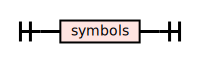

symbols


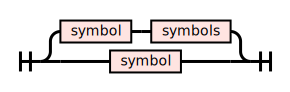

symbol


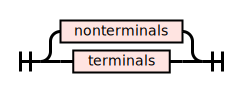

nonterminals


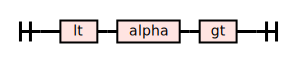

lt


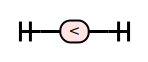

gt


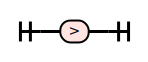

alpha


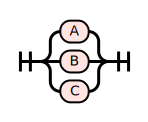

terminals


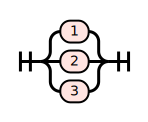

In [146]:
syntax_diagram(prod_line_grammar(["A", "B", "C"], ["1", "2", "3"]))

In [147]:
def make_rule(nonterminals, terminals, num_alts):
    prod_grammar = prod_line_grammar(nonterminals, terminals)

    gf = GrammarFuzzer(prod_grammar, min_nonterminals=3, max_nonterminals=5)
    name = "<%s>" % ''.join(random.choices(string.ascii_uppercase, k=3))

    return (name, [gf.fuzz() for _ in range(num_alts)])

In [148]:
make_rule(["A", "B", "C"], ["1", "2", "3"], 3)

('<FYU>', ['<C>23', '<C><A>', '<B><C>3'])

In [149]:
from Grammars import unreachable_nonterminals

In [150]:
def make_grammar(num_symbols=3, num_alts=3):
    terminals = list(string.ascii_lowercase)
    grammar = {}
    name = None
    for _ in range(num_symbols):
        nonterminals = [k[1:-1] for k in grammar.keys()]
        name, expansions = \
            make_rule(nonterminals, terminals, num_alts)
        grammar[name] = expansions

    grammar[START_SYMBOL] = [name]
    
    # Remove unused parts
    for nonterminal in unreachable_nonterminals(grammar):
        del grammar[nonterminal]
    
    assert is_valid_grammar(grammar)
    
    return grammar

In [151]:
make_grammar()

{'<ILY>': ['lhp', 'gta', 'sm'],
 '<FZD>': ['qn<ILY>', 'e<ILY><ILY>g', '<ILY>f<ILY>m'],
 '<ITK>': ['<ILY>fyy', '<ILY><ILY>t', '<FZD>l<ILY>ao'],
 '<start>': ['<ITK>']}

Now we verify if our arbitrary grammars can be used by the Earley parser.

In [152]:
for i in range(5):
    my_grammar = make_grammar()
    print(my_grammar)
    parser = EarleyParser(my_grammar)
    mygf = GrammarFuzzer(my_grammar)
    s = mygf.fuzz()
    print(s)
    for tree in parser.parse(s):
        assert tree_to_string(tree) == s
        display_tree(tree)

{'<SCS>': ['ts', 'f', 'ng'], '<BQN>': ['wm<SCS>', '<SCS>wi', '<SCS>hw'], '<UZC>': ['gyk<BQN>br', '<SCS>iqp', '<BQN>vb'], '<start>': ['<UZC>']}
fhwvb
{'<CRN>': ['meze', 'de', 'cpcv'], '<AIS>': ['<CRN>hb', 'dc<CRN>', 'pa<CRN>x'], '<MAO>': ['<CRN>su', '<CRN>hj', '<CRN><AIS>g'], '<start>': ['<MAO>']}
dehj
{'<MFY>': ['y', 'w', ''], '<ZOY>': ['oe<MFY>', 'h<MFY>u', 'lowr'], '<HFT>': ['<ZOY>ro', '<ZOY>w', '<ZOY><ZOY>w'], '<start>': ['<HFT>']}
lowrro
{'<CYC>': ['cg', 'enl', 'ovd'], '<TUV>': ['<CYC>hf', '<CYC>nl', 'fhg'], '<MOQ>': ['g<TUV>g', '<CYC>ix', '<CYC><TUV><CYC>'], '<start>': ['<MOQ>']}
cgix
{'<WJJ>': ['dszdlh', 'j', 'fd'], '<RQM>': ['<WJJ>wx', 'xs<WJJ><WJJ>', '<WJJ>x'], '<JNY>': ['<WJJ>oa', '<WJJ><WJJ>cx', 'xd<RQM>'], '<start>': ['<JNY>']}
joa


With this, we have completed both implementation and testing of *arbitrary* CFG, which can now be used along with `LangFuzzer` to generate better fuzzing inputs.

## Background


Numerous parsing techniques exist that can parse a given string using a
given grammar, and produce corresponding derivation tree or trees. However,
some of these techniques work only on specific classes of grammars.
These classes of grammars are named after the specific kind of parser
that can accept grammars of that category. That is, the upper bound for
the capabilities of the parser defines the grammar class named after that
parser.

The *LL* and *LR* parsing are the main traditions in parsing. Here, *LL* means left-to-right, leftmost derivation, and it represents a top-down approach. On the other hand, and LR (left-to-right, rightmost derivation) represents a bottom-up approach. Another way to look at it is that LL parsers compute the derivation tree incrementally in *pre-order* while LR parsers compute the derivation tree in *post-order* \cite{pingali2015graphical}).

Different classes of grammars differ in the features that are available to
the user for writing a grammar of that class. That is, the corresponding
kind of parser will be unable to parse a grammar that makes use of more
features than allowed. For example, the `A2_GRAMMAR` is an *LL*
grammar because it lacks left recursion, while `A1_GRAMMAR` is not an
*LL* grammar. This is because an *LL* parser parses
its input from left to right, and constructs the leftmost derivation of its
input by expanding the nonterminals it encounters. If there is a left
recursion in one of these rules, an *LL* parser will enter an infinite loop.

Similarly, a grammar is LL(k) if it can be parsed by an LL parser with k lookahead token, and LR(k) grammar can only be parsed with LR parser with at least k lookahead tokens. These grammars are interesting because both LL(k) and LR(k) grammars have $O(n)$ parsers, and can be used with relatively restricted computational budget compared to other grammars.

The languages for which one can provide an *LL(k)* grammar is called *LL(k)* languages (where k is the minimum lookahead required). Similarly, *LR(k)* is defined as the set of languages that have an *LR(k)* grammar. In terms of languages, LL(k) $\subset$ LL(k+1) and LL(k) $\subset$ LR(k), and *LR(k)* $=$ *LR(1)*. All deterministic *CFLs* have an *LR(1)* grammar. However, there exist *CFLs* that are inherently ambiguous \cite{ogden1968helpful}, and for these, one can't provide an *LR(1)* grammar.

The other main parsing algorithms for *CFGs* are GLL \cite{scott2010gll}, GLR \cite{tomita1987efficient,tomita2012generalized}, and CYK \cite{grune2008parsing}.
The ALL(\*) (used by ANTLR) on the other hand is a grammar representation that uses *Regular Expression* like predicates (similar to advanced PEGs – see [Exercise](#Exercise-3:-PEG-Predicates)) rather than a fixed lookahead. Hence, ALL(\*) can accept a larger class of grammars than CFGs.

In terms of computational limits of parsing, the main CFG parsers have a complexity of $O(n^3)$ for arbitrary grammars. However, parsing with arbitrary *CFG* is reducible to boolean matrix multiplication \cite{Valiant1975} (and the reverse \cite{Lee2002}). This is at present bounded by $O(2^{23728639}$)  \cite{LeGall2014}. Hence, worse case complexity for parsing arbitrary CFG is likely to remain close to cubic.

Regarding PEGs, the actual class of languages that is expressible in *PEG* is currently unknown. In particular, we know that *PEGs* can express certain languages such as $a^n b^n c^n$. However, we do not know if there exist *CFLs* that are not expressible with *PEGs*. In Section 2.3, we provided an instance of a counter-intuitive PEG grammar. While important for our purposes (we use grammars for generation of inputs) this is not a criticism of parsing with PEGs. PEG focuses on writing grammars for recognizing a given language, and not necessarily in interpreting what language an arbitrary PEG might yield. Given a Context-Free Language to parse, it is almost always possible to write a grammar for it in PEG, and given that 1) a PEG can parse any string in $O(n)$ time, and 2) at present we know of no CFL that can't be expressed as a PEG, and 3) compared with *LR* grammars, a PEG is often more intuitive because it allows top-down interpretation, when writing a parser for a language, PEGs should be under serious consideration.

## Synopsis

This chapter introduces `Parser` classes, parsing a string into a _derivation tree_ as introduced in the [chapter on efficient grammar fuzzing](GrammarFuzzer.ipynb).  Two important parser classes are provided:

* [Parsing Expression Grammar parsers](#Parsing-Expression-Grammars) (`PEGParser`), which are very efficient, but limited to specific grammar structure; and
* [Earley parsers](#Parsing-Context-Free-Grammars) (`EarleyParser`), which accept any kind of context-free grammars.

Using any of these is fairly easy, though.  First, instantiate them with a grammar:

In [153]:
from Grammars import US_PHONE_GRAMMAR

In [154]:
us_phone_parser = EarleyParser(US_PHONE_GRAMMAR)

Then, use the `parse()` method to retrieve a list of possible derivation trees:

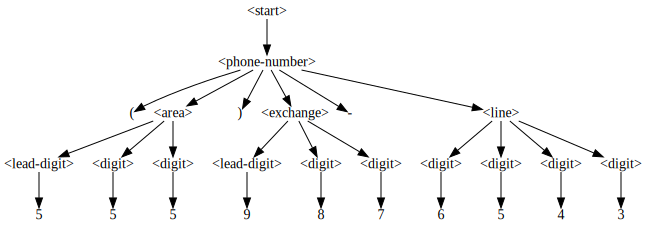

In [155]:
trees = us_phone_parser.parse("(555)987-6543")
tree = list(trees)[0]
display_tree(tree)

These derivation trees can then be used for test generation, notably for mutating and recombining existing inputs.

## Lessons Learned

* Grammars can be used to generate derivation trees for a given string.
* Parsing Expression Grammars are intuitive, and easy to implement, but require care to write.
* Earley Parsers can parse arbitrary Context Free Grammars.


## Next Steps

* Use parsed inputs to [recombine existing inputs](LangFuzzer.ipynb)

## Exercises

### Exercise 1: An Alternative Packrat

In the _Packrat_ parser, we showed how one could implement a simple _PEG_ parser. That parser kept track of the current location in the text using an index. Can you modify the parser so that it simply uses the current substring rather than tracking the index? That is, it should no longer have the `at` parameter.

**Solution.**  Here is a possible solution:

In [156]:
class PackratParser(Parser):
    def parse_prefix(self, text):
        txt, res = self.unify_key(self.start_symbol(), text)
        return len(txt), [res]

    def parse(self, text):
        remain, res = self.parse_prefix(text)
        if remain:
            raise SyntaxError("at " + res)
        return res

    def unify_rule(self, rule, text):
        results = []
        for token in rule:
            text, res = self.unify_key(token, text)
            if res is None:
                return text, None
            results.append(res)
        return text, results

    def unify_key(self, key, text):
        if key not in self.cgrammar:
            if text.startswith(key):
                return text[len(key):], (key, [])
            else:
                return text, None
        for rule in self.cgrammar[key]:
            text_, res = self.unify_rule(rule, text)
            if res:
                return (text_, (key, res))
        return text, None

In [157]:
mystring = "1 + (2 * 3)"
for tree in PackratParser(EXPR_GRAMMAR).parse(mystring):
    assert tree_to_string(tree) == mystring
    display_tree(tree)

### Exercise 2: More PEG Syntax

The _PEG_ syntax provides a few notational conveniences reminiscent of regular expressions. For example, it supports the following operators (letters `T` and `A` represents tokens that can be either terminal or nonterminal. `ε` is an empty string, and `/` is the ordered choice operator similar to the non-ordered choice operator `|`):

* `T?` represents an optional greedy match of T and `A := T?` is equivalent to `A := T/ε`.
* `T*` represents zero or more greedy matches of `T` and `A := T*` is equivalent to `A := T A/ε`.
* `T+` represents one or more greedy matches – equivalent to `TT*`

If you look at the three notations above, each can be represented in the grammar in terms of basic syntax.
Remember the exercise from [the chapter on grammars](Grammars.ipynb) that developed `define_ex_grammar()` that can represent grammars as Python code? extend `define_ex_grammar()` to `define_peg()` to support the above notational conveniences. The decorator should rewrite a given grammar that contains these notations to an equivalent grammar in basic syntax.

### Exercise 3: PEG Predicates

Beyond these notational conveniences, it also supports two predicates that can provide a powerful lookahead facility that does not consume any input.

* `T&A` represents an _And-predicate_ that matches `T` if `T` is matched, and it is immediately followed by `A`
* `T!A` represents a _Not-predicate_ that matches `T` if `T` is matched, and it is *not* immediately followed by `A`

Implement these predicates in our _PEG_ parser.

### Exercise 4: Earley Fill Chart

In the `Earley Parser`, `Column` class, we keep the states both as a `list` and also as a `dict` even though `dict` is ordered. Can you explain why?

**Hint**: see the `fill_chart` method.

**Solution.** Python allows us to append to a list in flight, while a dict, eventhough it is ordered does not allow that facility.

That is, the following will work

```python
values = [1]
for v in values:
   values.append(v*2)
```

However, the following will result in an error
```python
values = {1:1}
for v in values:
    values[v*2] = v*2
```

In the `fill_chart`, we make use of this facility to modify the set of states we are iterating on, on the fly.

### Exercise 5: Leo Parser

One of the problems with the original Earley parser is that while it can parse strings using arbitrary _Context Free Gramamrs_, its performance on right-recursive grammars is quadratic. That is, it takes $O(n^2)$ runtime and space for parsing with right-recursive grammars. For example, consider the parsing of the following string by two different grammars `LR_GRAMMAR` and `RR_GRAMMAR`.

In [158]:
mystring = 'aaaaaa'

To see the problem, we need to enable logging. Here is the logged version of parsing with the `LR_GRAMMAR`

In [159]:
result = EarleyParser(LR_GRAMMAR, log=True).parse(mystring)
for _ in result: pass # consume the generator so that we can see the logs

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= <A> a |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= <A> a |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= <A> a |(0,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= <A> a |(0,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= <A> a |(0,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= <A> a |(0,6)
<start>:= <A> |(0,6) 



Compare that to the parsing of `RR_GRAMMAR` as seen below:

In [160]:
result = EarleyParser(RR_GRAMMAR, log=True).parse(mystring)
for _ in result: pass

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= |(1,1)
<A>:= a <A> |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= |(2,2)
<A>:= a <A> |(1,2)
<A>:= a <A> |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= |(3,3)
<A>:= a <A> |(2,3)
<A>:= a <A> |(1,3)
<A>:= a <A> |(0,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= |(4,4)
<A>:= a <A> |(3,4)
<A>:= a <A> |(2,4)
<A>:= a <A> |(1,4)
<A>:= a <A> |(0,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= |(5,5)
<A>:= a <A> |(4,5)
<A>:= a <A> |(3,5)
<A>:= a <A> |(2,5)
<A>:= a <A> |(1,5)
<A>:= a <A> |(0,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= |(6,6)
<A>:= a <A> |(5,6)
<A>:= a <A> |(4,6)
<A>:= a <A> |(3,6)
<A>:= a <A> |(2,6)
<A>:= a <A> |(1,6)
<A>:= a <A> |(0,6)
<start>:= <A> |(0,6) 



As can be seen from the parsing log for each letter, the number of states with representation `<A>: a <A> ● (i, j)` increases at each stage, and these are simply a left over from the previous letter. They do not contribute anything more to the parse other than to simply complete these entries. However, they take up space, and require resources for inspection, contributing a factor of `n` in analysis.

Joop Leo \cite{Leo1991} found that this inefficiency can be avoided by detecting right recursion. The idea is that before starting the `completion` step, check whether the current item has a _deterministic reduction path_. If such a path exists, add a copy of the topmost element of the _deteministic reduction path_ to the current column, and return. If not, perform the original `completion` step.


**Definition 2.1**: An item is said to be on the deterministic reduction path above $[A \rightarrow  \gamma., i]$ if it is $[B \rightarrow \alpha A ., k]$ with $[B \rightarrow \alpha . A, k]$ being the only item in $ I_i $ with the dot in front of A, or if it is on the deterministic reduction path above $[B \rightarrow \alpha A ., k]$. An item on such a path is called *topmost* one if there is no item on the deterministic reduction path above it\cite{Leo1991}.

Finding a _deterministic reduction path_ is as follows:

Given a complete state, represented by `<A> : seq_1 ● (s, e)` where `s` is the starting column for this rule, and `e` the current column, there is a _deterministic reduction path_ **above** it if two constraints are satisfied.

1. There exist a *single* item in the form `<B> : seq_2 ● <A> (k, s)` in column `s`.
2. That should be the *single* item in s with dot in front of `<A>`

The resulting item is of the form `<B> : seq_2 <A> ● (k, e)`, which is simply item from (1) advanced, and is considered above `<A>:.. (s, e)` in the deterministic reduction path.
The `seq_1` and `seq_2` are arbitrary symbol sequences.

This forms the following chain of links, with `<A>:.. (s_1, e)` being the child of `<B>:.. (s_2, e)` etc.

Here is one way to visualize the chain:
```
<C> : seq_3 <B> ● (s_3, e)  
             |  constraints satisfied by <C> : seq_3 ● <B> (s_3, s_2)
            <B> : seq_2 <A> ● (s_2, e)  
                         | constraints satisfied by <B> : seq_2 ● <A> (s_2, s_1)
                        <A> : seq_1 ● (s_1, e)
```

Essentially, what we want to do is to identify potential deterministic right recursion candidates, perform completion on them, and *throw away the result*. We do this until we reach the top. See Grune et al.~\cite{grune2008parsing} for further information.

Note that the completions are in the same column (`e`), with each candidates with constraints satisfied 
in further and further earlier columns (as shown below):
```
<C> : seq_3 ● <B> (s_3, s_2)  -->              <C> : seq_3 <B> ● (s_3, e)
               |
              <B> : seq_2 ● <A> (s_2, s_1) --> <B> : seq_2 <A> ● (s_2, e)  
                             |
                            <A> : seq_1 ●                        (s_1, e)
```

Following this chain, the topmost item is the item `<C>:.. (s_3, e)` that does not have a parent. The topmost item needs to be saved is called a *transitive* item by Leo, and it is associated with the non-terminal symbol that started the lookup. The transitive item needs to be added to each column we inspect.

Here is the skeleton for the parser `LeoParser`.

In [161]:
class LeoParser(EarleyParser):
    def complete(self, col, state):
        return self.leo_complete(col, state)

    def leo_complete(self, col, state):
        detred = self.deterministic_reduction(state)
        if detred:
            col.add(detred.copy())
        else:
            self.earley_complete(col, state)

    def deterministic_reduction(self, state):
        raise NotImplemented()

Can you implement the `deterministic_reduction()` method to obtain the topmost element?

**Solution.**  Here is a possible solution:

First, we update our `Column` class with the ability to add transitive items. Note that, while Leo asks the transitive to be added to the set $ I_k $ there is no actual requirement for the transitive states to be added to the `states` list. The transitive items are only intended for memoization and not for the `fill_chart()` method. Hence, we track them separately.

In [162]:
class Column(Column):
    def __init__(self, index, letter):
        self.index, self.letter = index, letter
        self.states, self._unique, self.transitives = [], {}, {}

    def add_transitive(self, key, state):
        assert key not in self.transitives
        self.transitives[key] = state
        return self.transitives[key]

Remember the picture we drew of the deterministic path?
```
    <C> : seq_3 <B> ● (s_3, e)  
                 |  constraints satisfied by <C> : seq_3 ● <B> (s_3, s_2)
                <B> : seq_2 <A> ● (s_2, e)  
                             | constraints satisfied by <B> : seq_2 ● <A> (s_2, s_1)
                            <A> : seq_1 ● (s_1, e)
```

We define a function `uniq_postdot()` that given the item `<A> := seq_1 ● (s_1, e)`, returns a `<B> : seq_2 ● <A> (s_2, s_1)` that satisfies the constraints mentioned in the above picture.

In [163]:
class LeoParser(LeoParser):
    def uniq_postdot(self, st_A):
        col_s1 = st_A.s_col
        parent_states = [
            s for s in col_s1.states if s.expr and s.at_dot() == st_A.name
        ]
        if len(parent_states) > 1:
            return None
        matching_st_B = [s for s in parent_states if s.dot == len(s.expr) - 1]
        return matching_st_B[0] if matching_st_B else None

In [164]:
lp = LeoParser(RR_GRAMMAR)
[(str(s), str(lp.uniq_postdot(s))) for s in columns[-1].states]

[('<D>:= d |(3,4)', '<B>:= | <D>(3,3)'),
 ('<B>:= <D> |(3,4)', '<start>:= <A> | <B>(0,3)'),
 ('<start>:= <A> <B> |(0,4)', 'None')]

We next define the function `get_top()` that is the core of deterministic reduction which gets the topmost state above the current state (`A`).

In [165]:
class LeoParser(LeoParser):
    def get_top(self, state_A):
        st_B_inc = self.uniq_postdot(state_A)
        if not st_B_inc:
            return None
        
        t_name = st_B_inc.name
        if t_name in st_B_inc.e_col.transitives:
            return st_B_inc.e_col.transitives[t_name]

        st_B = st_B_inc.advance()

        top = self.get_top(st_B) or st_B
        return st_B_inc.e_col.add_transitive(t_name, top)

Once we have the machinery in place, `deterministic_reduction()` itself is simply a wrapper to call `get_top()`

In [166]:
class LeoParser(LeoParser):
    def deterministic_reduction(self, state):
        return self.get_top(state)

In [167]:
lp = LeoParser(RR_GRAMMAR)
columns = lp.chart_parse(mystring, lp.start_symbol())
[(str(s), str(lp.get_top(s))) for s in columns[-1].states]

[('<A>:= a | <A>(5,6)', '<start>:= <A> |(0,-1)'),
 ('<A>:= | a <A>(6,6)', '<start>:= <A> |(0,-1)'),
 ('<A>:= |(6,6)', '<start>:= <A> |(0,-1)'),
 ('<A>:= a <A> |(5,6)', '<start>:= <A> |(0,-1)'),
 ('<start>:= <A> |(0,6)', 'None')]

Now, both LR and RR grammars should work within $O(n)$ bounds.

In [168]:
result = LeoParser(RR_GRAMMAR, log=True).parse(mystring)
for _ in result: pass

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= |(1,1)
<A>:= a <A> |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= |(2,2)
<A>:= a <A> |(1,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= |(3,3)
<A>:= a <A> |(2,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= |(4,4)
<A>:= a <A> |(3,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= |(5,5)
<A>:= a <A> |(4,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= |(6,6)
<A>:= a <A> |(5,6)
<start>:= <A> |(0,6) 



We verify the Leo parser with a few more right recursive grammars.

In [169]:
RR_GRAMMAR2 = {
    '<start>': ['<A>'],
    '<A>': ['ab<A>', ''],
}
mystring2 = 'ababababab'

In [170]:
result = LeoParser(RR_GRAMMAR2, log=True).parse(mystring2)
for _ in result: pass

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
 

b chart[2]
<A>:= |(2,2)
<A>:= a b <A> |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
 

b chart[4]
<A>:= |(4,4)
<A>:= a b <A> |(2,4)
<start>:= <A> |(0,4) 

a chart[5]
 

b chart[6]
<A>:= |(6,6)
<A>:= a b <A> |(4,6)
<start>:= <A> |(0,6) 

a chart[7]
 

b chart[8]
<A>:= |(8,8)
<A>:= a b <A> |(6,8)
<start>:= <A> |(0,8) 

a chart[9]
 

b chart[10]
<A>:= |(10,10)
<A>:= a b <A> |(8,10)
<start>:= <A> |(0,10) 



In [171]:
RR_GRAMMAR3 = {
    '<start>': ['c<A>'],
    '<A>': ['ab<A>', ''],
}
mystring3 = 'cababababab'

In [172]:
result = LeoParser(RR_GRAMMAR3, log=True).parse(mystring3)
for _ in result: pass

None chart[0]
 

c chart[1]
<A>:= |(1,1)
<start>:= c <A> |(0,1) 

a chart[2]
 

b chart[3]
<A>:= |(3,3)
<A>:= a b <A> |(1,3)
<start>:= c <A> |(0,3) 

a chart[4]
 

b chart[5]
<A>:= |(5,5)
<A>:= a b <A> |(3,5)
<start>:= c <A> |(0,5) 

a chart[6]
 

b chart[7]
<A>:= |(7,7)
<A>:= a b <A> |(5,7)
<start>:= c <A> |(0,7) 

a chart[8]
 

b chart[9]
<A>:= |(9,9)
<A>:= a b <A> |(7,9)
<start>:= c <A> |(0,9) 

a chart[10]
 

b chart[11]
<A>:= |(11,11)
<A>:= a b <A> |(9,11)
<start>:= c <A> |(0,11) 



In [173]:
RR_GRAMMAR4 = {
    '<start>': ['<A>c'],
    '<A>': ['ab<A>', ''],
}
mystring4 = 'ababababc'

In [174]:
result = LeoParser(RR_GRAMMAR4, log=True).parse(mystring4)
for _ in result: pass

None chart[0]
<A>:= |(0,0) 

a chart[1]
 

b chart[2]
<A>:= |(2,2)
<A>:= a b <A> |(0,2) 

a chart[3]
 

b chart[4]
<A>:= |(4,4)
<A>:= a b <A> |(2,4)
<A>:= a b <A> |(0,4) 

a chart[5]
 

b chart[6]
<A>:= |(6,6)
<A>:= a b <A> |(4,6)
<A>:= a b <A> |(0,6) 

a chart[7]
 

b chart[8]
<A>:= |(8,8)
<A>:= a b <A> |(6,8)
<A>:= a b <A> |(0,8) 

c chart[9]
<start>:= <A> c |(0,9) 



In [175]:
RR_GRAMMAR5 = {
    '<start>': ['<A>'],
    '<A>': ['ab<B>', ''],
    '<B>': ['<A>'],
}
mystring5 = 'abababab'

In [176]:
result = LeoParser(RR_GRAMMAR5, log=True).parse(mystring5)
for _ in result: pass

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
 

b chart[2]
<A>:= a b <B> |(0,2)
<A>:= |(2,2)
<B>:= <A> |(2,2)
<start>:= <A> |(0,2) 

a chart[3]
 

b chart[4]
<A>:= a b <B> |(2,4)
<A>:= |(4,4)
<B>:= <A> |(4,4)
<start>:= <A> |(0,4) 

a chart[5]
 

b chart[6]
<A>:= a b <B> |(4,6)
<A>:= |(6,6)
<B>:= <A> |(6,6)
<start>:= <A> |(0,6) 

a chart[7]
 

b chart[8]
<A>:= a b <B> |(6,8)
<A>:= |(8,8)
<B>:= <A> |(8,8)
<start>:= <A> |(0,8) 



In [177]:
RR_GRAMMAR6 = {
    '<start>': ['<A>'],
    '<A>': ['a<B>', ''],
    '<B>': ['b<A>'],
}
mystring6 = 'abababab'

In [178]:
result = LeoParser(RR_GRAMMAR6, log=True).parse(mystring6)
for _ in result: pass

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
 

b chart[2]
<A>:= |(2,2)
<B>:= b <A> |(1,2)
<start>:= <A> |(0,2) 

a chart[3]
 

b chart[4]
<A>:= |(4,4)
<B>:= b <A> |(3,4)
<start>:= <A> |(0,4) 

a chart[5]
 

b chart[6]
<A>:= |(6,6)
<B>:= b <A> |(5,6)
<start>:= <A> |(0,6) 

a chart[7]
 

b chart[8]
<A>:= |(8,8)
<B>:= b <A> |(7,8)
<start>:= <A> |(0,8) 



In [179]:
RR_GRAMMAR7 = {
    '<start>': ['<A>'],
    '<A>': ['a<A>', 'a'],
}
mystring7 = 'aaaaaaaa'

In [180]:
result = LeoParser(RR_GRAMMAR7, log=True).parse(mystring7)
for _ in result: pass

None chart[0]
 

a chart[1]
<A>:= a |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= a |(1,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= a |(2,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= a |(3,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= a |(4,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= a |(5,6)
<start>:= <A> |(0,6) 

a chart[7]
<A>:= a |(6,7)
<start>:= <A> |(0,7) 

a chart[8]
<A>:= a |(7,8)
<start>:= <A> |(0,8) 



We verify that our parser works correctly on `LR_GRAMMAR` too.

In [181]:
result = LeoParser(LR_GRAMMAR, log=True).parse(mystring)
for _ in result: pass

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= <A> a |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= <A> a |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= <A> a |(0,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= <A> a |(0,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= <A> a |(0,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= <A> a |(0,6)
<start>:= <A> |(0,6) 



__Advanced:__ We have fixed the complexity bounds. However, because we are saving only the topmost item of a right recursion, we need to fix our parser to be aware of our fix while extracting parse trees. Can you fix it?

__Hint:__ Leo suggests simply transforming the Leo item sets to normal Earley sets, with the results from deterministic reduction expanded to their originals. For that, keep in mind the picture of constraint chain we drew earlier.

**Solution.** Here is a possible solution.

We first change the definition of `add_transitive()` so that results of deterministic reduction can be identified later.

In [182]:
class Column(Column):
    def add_transitive(self, key, state):
        assert key not in self.transitives
        self.transitives[key] = TState(state.name, state.expr, state.dot,
                                       state.s_col, state.e_col)
        return self.transitives[key]

We also need a `back()` method to create the constraints.

In [183]:
class State(State):
    def back(self):
        return TState(self.name, self.expr, self.dot - 1, self.s_col, self.e_col)

We update `copy()` to make `TState` items instead.

In [184]:
class TState(State):
    def copy(self):
        return TState(self.name, self.expr, self.dot, self.s_col, self.e_col)

We now modify the `LeoParser` to keep track of the chain of constrains that we mentioned earlier.

In [185]:
class LeoParser(LeoParser):
    def __init__(self, grammar, **kwargs):
        super().__init__(grammar, **kwargs)
        self._postdots = {}

Next, we update the `uniq_postdot()` so that it tracks the chain of links.

In [186]:
class LeoParser(LeoParser):
    def uniq_postdot(self, st_A):
        col_s1 = st_A.s_col
        parent_states = [
            s for s in col_s1.states if s.expr and s.at_dot() == st_A.name
        ]
        if len(parent_states) > 1:
            return None
        matching_st_B = [s for s in parent_states if s.dot == len(s.expr) - 1]
        if matching_st_B:
            self._postdots[matching_st_B[0]._t()] = st_A
            return matching_st_B[0]
        return None
      

We next define a method `expand_tstate()` that, when given a `TState`, generates all the intermediate links that we threw away earlier for a given end column.

In [187]:
class LeoParser(LeoParser):
    def expand_tstate(self, state, e):
        if state._t() not in self._postdots:
            return
        c_C = self._postdots[state._t()]
        e.add(c_C.advance())
        self.expand_tstate(c_C.back(), e)

We define a `rearrange()` method to generate a reversed table where each column contains states that start at that column.

In [188]:
class LeoParser(LeoParser):
    def rearrange(self, table):
        f_table = [Column(c.index, c.letter) for c in table]
        for col in table:
            for s in col.states:
                f_table[s.s_col.index].states.append(s)
        return f_table

Here is the rearranged table. (Can you explain why the Column 0 has a large number of `<start>` items?)

In [189]:
ep = LeoParser(RR_GRAMMAR)
columns = ep.chart_parse(mystring, ep.start_symbol())
r_table = ep.rearrange(columns)
for col in r_table:
    print(col, "\n")

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0)
<A>:= a <A> |(0,1)
<start>:= <A> |(0,1)
<start>:= <A> |(0,2)
<start>:= <A> |(0,3)
<start>:= <A> |(0,4)
<start>:= <A> |(0,5)
<start>:= <A> |(0,6) 

a chart[1]
<A>:= |(1,1)
<A>:= a <A> |(1,2) 

a chart[2]
<A>:= |(2,2)
<A>:= a <A> |(2,3) 

a chart[3]
<A>:= |(3,3)
<A>:= a <A> |(3,4) 

a chart[4]
<A>:= |(4,4)
<A>:= a <A> |(4,5) 

a chart[5]
<A>:= |(5,5)
<A>:= a <A> |(5,6) 

a chart[6]
<A>:= |(6,6) 



We save the result of rearrange before going into `parse_forest()`.

In [190]:
class LeoParser(LeoParser):
    def parse(self, text):
        cursor, states = self.parse_prefix(text)
        start = next((s for s in states if s.finished()), None)
        if cursor < len(text) or not start:
            raise SyntaxError("at " + repr(text[cursor:]))

        self.r_table = self.rearrange(self.table)
        forest = self.extract_trees(self.parse_forest(self.table, start))
        for tree in forest:
            yield self.prune_tree(tree)

Finally, during `parse_forest()`, we first check to see if it is a transitive state, and if it is, expand it to the original sequence of states using `traverse_constraints()`.

In [191]:
class LeoParser(LeoParser):
    def parse_forest(self, chart, state):
        if isinstance(state, TState):
            self.expand_tstate(state.back(), state.e_col)
        
        return super().parse_forest(chart, state)

This completes our implementation of `LeoParser`.

We check whether the previously defined right recursive grammars parse and return the correct parse trees.

In [192]:
result = LeoParser(RR_GRAMMAR).parse(mystring)
for tree in result:
    assert mystring == tree_to_string(tree)

In [193]:
result = LeoParser(RR_GRAMMAR2).parse(mystring2)
for tree in result:
    assert mystring2 == tree_to_string(tree)

In [194]:
result = LeoParser(RR_GRAMMAR3).parse(mystring3)
for tree in result:
    assert mystring3 == tree_to_string(tree)

In [195]:
result = LeoParser(RR_GRAMMAR4).parse(mystring4)
for tree in result:
    assert mystring4 == tree_to_string(tree)

In [196]:
result = LeoParser(RR_GRAMMAR5).parse(mystring5)
for tree in result:
    assert mystring5 == tree_to_string(tree)

In [197]:
result = LeoParser(RR_GRAMMAR6).parse(mystring6)
for tree in result:
    assert mystring6 == tree_to_string(tree)

In [198]:
result = LeoParser(RR_GRAMMAR7).parse(mystring7)
for tree in result:
    assert mystring7 == tree_to_string(tree)

In [199]:
result = LeoParser(LR_GRAMMAR).parse(mystring)
for tree in result:
    assert mystring == tree_to_string(tree)

In [200]:
RR_GRAMMAR8 = {
   '<start>': ['<A>'],
   '<A>': ['a<A>', 'a']
}
mystring8 = 'aa'

In [201]:
RR_GRAMMAR9 = {
   '<start>': ['<A>'],
   '<A>': ['<B><A>', '<B>'],
   '<B>': ['b']
}
mystring9 = 'bbbbbbb'

In [202]:
result = LeoParser(RR_GRAMMAR8).parse(mystring8)
for tree in result:
    print(repr(tree_to_string(tree)))
    assert mystring8 == tree_to_string(tree)

'aa'
'aa'


In [203]:
result = LeoParser(RR_GRAMMAR9).parse(mystring9)
for tree in result:
    print(repr(tree_to_string(tree)))
    assert mystring9 == tree_to_string(tree)

'bbbbbbb'
'bbbbbbb'


### Exercise 6: Filtered Earley Parser

One of the problems with our Earley and Leo Parsers is that it can get stuck in infinite loops when parsing with grammars that contain token repetitions in alternatives. For example, consider the grammar below.

In [204]:
RECURSION_GRAMMAR = {
    "<start>": ["<A>"],
    "<A>": ["<A>", "<A>aa", "AA", "<B>"],
    "<B>": ["<C>", "<C>cc" ,"CC"],
    "<C>": ["<B>", "<B>bb", "BB"]
}

With this grammar, one can produce an infinite chain of derivations of `<A>`, (direct recursion) or an infinite chain of derivations of `<B> -> <C> -> <B> ...` (indirect recursion). The problem is that, our implementation can get stuck trying to derive one of these infinite chains. One possibility is to use the `LazyExtractor`. Another, is to simply avoid generating such chains.

In [205]:
from ExpectError import ExpectTimeout

In [206]:
with ExpectTimeout(1, print_traceback=False):
    mystring = 'AA'
    parser = LeoParser(RECURSION_GRAMMAR)
    tree, *_ = parser.parse(mystring)
    assert tree_to_string(tree) == mystring
    display_tree(tree)

RecursionError: maximum recursion depth exceeded in comparison (expected)


Can you implement a solution such that any tree that contains such a chain is discarded?

**Solution.** Here is a possible solution.

In [207]:
class FilteredLeoParser(LeoParser):
    def forest(self, s, kind, seen, chart):
        return self.parse_forest(chart, s, seen) if kind == 'n' else (s, [])

    def parse_forest(self, chart, state, seen=None):
        if isinstance(state, TState):
            self.expand_tstate(state.back(), state.e_col)
        
        def was_seen(chain, s):
            if isinstance(s, str):
                return False
            if len(s.expr) > 1:
                return False
            return s in chain

        if len(state.expr) > 1:  # things get reset if we have a non loop
            seen = set()
        elif seen is None:  # initialization
            seen = {state}

        pathexprs = self.parse_paths(state.expr, chart, state.s_col.index,
                                     state.e_col.index) if state.expr else []
        return state.name, [[(s, k, seen | {s}, chart)
                             for s, k in reversed(pathexpr)
                             if not was_seen(seen, s)] for pathexpr in pathexprs]

With the `FilteredLeoParser`, we should be able to recover minimal parse trees in reasonable time.

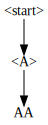

In [208]:
mystring = 'AA'
parser = FilteredLeoParser(RECURSION_GRAMMAR)
tree, *_ = parser.parse(mystring)
assert tree_to_string(tree) == mystring
display_tree(tree)

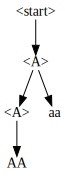

In [209]:
mystring = 'AAaa'
parser = FilteredLeoParser(RECURSION_GRAMMAR)
tree, *_ = parser.parse(mystring)
assert tree_to_string(tree) == mystring
display_tree(tree)

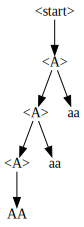

In [210]:
mystring = 'AAaaaa'
parser = FilteredLeoParser(RECURSION_GRAMMAR)
tree, *_ = parser.parse(mystring)
assert tree_to_string(tree) == mystring
display_tree(tree)

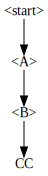

In [211]:
mystring = 'CC'
parser = FilteredLeoParser(RECURSION_GRAMMAR)
tree, *_ = parser.parse(mystring)
assert tree_to_string(tree) == mystring
display_tree(tree)

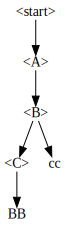

In [212]:
mystring = 'BBcc'
parser = FilteredLeoParser(RECURSION_GRAMMAR)
tree, *_ = parser.parse(mystring)
assert tree_to_string(tree) == mystring
display_tree(tree)

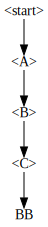

In [213]:
mystring = 'BB'
parser = FilteredLeoParser(RECURSION_GRAMMAR)
tree, *_ = parser.parse(mystring)
assert tree_to_string(tree) == mystring
display_tree(tree)

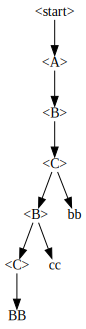

In [214]:
mystring = 'BBccbb'
parser = FilteredLeoParser(RECURSION_GRAMMAR)
tree, *_ = parser.parse(mystring)
assert tree_to_string(tree) == mystring
display_tree(tree)

As can be seen, we are able to recover minimal parse trees without hitting on infinite chains.

### Exercise 7: Iterative Earley Parser

Recursive algorithms are quite handy in some cases but sometimes we might want to have iteration instead of recursion due to memory or speed problems. 

Can you implement an iterative version of the `EarleyParser`? 

__Hint:__ In general, you can use a stack to replace a recursive algorithm with an iterative one. An easy way to do this is pushing the parameters onto a stack instead of passing them to the recursive function.

**Solution.** Here is a possible solution.

First, we define `parse_paths()` that extract paths from a parsed expression, which is very similar to the original.

In [215]:
class IterativeEarleyParser(EarleyParser):
    def parse_paths(self, named_expr_, chart, frm, til_):
        return_paths = []
        path_build_stack = [(named_expr_, til_, [])]

        def iter_paths(path_prefix, path, start, k, e):
            x = path_prefix + [(path, k)]
            if not e:
                return_paths.extend([x] if start == frm else [])
            else:
                path_build_stack.append((e, start, x))

        while path_build_stack:
            named_expr, til, path_prefix = path_build_stack.pop()
            *expr, var = named_expr

            starts = None
            if var not in self.cgrammar:
                starts = ([(var, til - len(var),
                        't')] if til > 0 and chart[til].letter == var else [])
            else:
                starts = [(s, s.s_col.index, 'n') for s in chart[til].states
                      if s.finished() and s.name == var]

            for s, start, k in starts:
                iter_paths(path_prefix, s, start, k, expr)

        return return_paths

Next we used these paths to recover the forest data structure using `parse_forest()`. Since `parse_forest()` does not recurse, we reuse the original definition. Next, we define `extract_a_tree()`

Now we are ready to extract trees from the forest using `extract_a_tree()`

In [216]:
class IterativeEarleyParser(IterativeEarleyParser):
    def choose_a_node_to_explore(self, node_paths, level_count):
        first, *rest = node_paths
        return first

    def extract_a_tree(self, forest_node_):
        start_node = (forest_node_[0], [])
        tree_build_stack = [(forest_node_, start_node[-1], 0)]

        while tree_build_stack:
            forest_node, tree, level_count = tree_build_stack.pop()
            name, paths = forest_node

            if not paths:
                tree.append((name, []))
            else:
                new_tree = []
                current_node = self.choose_a_node_to_explore(paths, level_count)
                for p in reversed(current_node):
                    new_forest_node = self.forest(*p)
                    tree_build_stack.append((new_forest_node, new_tree, level_count + 1))
                tree.append((name, new_tree))

        return start_node

For now, we simply extract the first tree found.

In [217]:
class IterativeEarleyParser(IterativeEarleyParser):
    def extract_trees(self, forest):
        yield self.extract_a_tree(forest)

Let's see if it works with some of the grammars we have seen so far.

In [218]:
test_cases = [
    (A1_GRAMMAR, '1-2-3+4-5'),
    (A2_GRAMMAR, '1+2'),
    (A3_GRAMMAR, '1+2+3-6=6-1-2-3'),
    (LR_GRAMMAR, 'aaaaa'),
    (RR_GRAMMAR, 'aa'),
    (DIRECTLY_SELF_REFERRING, 'select a from a'),
    (INDIRECTLY_SELF_REFERRING, 'select a from a'),
    (RECURSION_GRAMMAR, 'AA'),
    (RECURSION_GRAMMAR, 'AAaaaa'),
    (RECURSION_GRAMMAR, 'BBccbb')
]

for i, (grammar, text) in enumerate(test_cases):
    print(i, text)
    tree, *_ =  IterativeEarleyParser(grammar).parse(text)
    assert text == tree_to_string(tree)

0 1-2-3+4-5
1 1+2
2 1+2+3-6=6-1-2-3
3 aaaaa
4 aa
5 select a from a
6 select a from a
7 AA
8 AAaaaa
9 BBccbb


As can be seen, our `IterativeEarleyParser` is able to handle recursive grammars. However, it can only extract the first tree found. What should one do to get all possible parses? What we can do, is to keep track of options to explore at each `choose_a_node_to_explore()`. Next, capture in the nodes explored in a tree data structure, adding new paths each time a new leaf is expanded. See the `TraceTree` datastructure in the [chapter on Concolic fuzzing](ConcolicFuzzer.ipynb) for an example.

### Exercise 8: First Set of a Nonterminal

We previously gave a way to extract a the `nullable` (epsilon) set, which is often used for parsing.
Along with `nullable`, parsing algorithms often use two other sets [`first` and `follow`](https://en.wikipedia.org/wiki/Canonical_LR_parser#FIRST_and_FOLLOW_sets).
The first set of a terminal symbol is itself, and the first set of a nonterminal is composed of terminal symbols that can come at the beginning of any derivation
of that nonterminal. The first set of any nonterminal that can derive the empty string should contain `EPSILON`. For example, using our `A1_GRAMMAR`, the first set of both `<expr>` and `<start>` is `{0,1,2,3,4,5,6,7,8,9}`. The extraction first set for any self-recursive nonterminal is simple enough. One simply has to recursively compute the first set of the first element of its choice expressions. The computation of `first` set for a self-recursive nonterminal is tricky. One has to recursively compute the first set until one is sure that no more terminals can be added to the first set.

Can you implement the `first` set using our `fixpoint()` decorator?

**Solution.** The first set of all terminals is the set containing just themselves. So we initialize that first. Then we update the first set with rules that derive empty strings.

In [219]:
def firstset(grammar, nullable):
    first = {i: {i} for i in terminals(grammar)}
    for k in grammar:
        first[k] = {EPSILON} if k in nullable else set()
    return firstset_((rules(grammar), first, nullable))[1]

Finally, we rely on the `fixpoint` to update the first set with the contents of the current first set until the first set stops changing.

In [220]:
def first_expr(expr, first, nullable):
    tokens = set()
    for token in expr:
        tokens |= first[token]
        if token not in nullable:
            break
    return tokens

In [221]:
@fixpoint
def firstset_(arg):
    (rules, first, epsilon) = arg
    for A, expression in rules:
        first[A] |= first_expr(expression, first, epsilon)
    return (rules, first, epsilon)

In [222]:
firstset(canonical(A1_GRAMMAR), EPSILON)

{'7': {'7'},
 '+': {'+'},
 '2': {'2'},
 '-': {'-'},
 '8': {'8'},
 '1': {'1'},
 '0': {'0'},
 '3': {'3'},
 '4': {'4'},
 '6': {'6'},
 '5': {'5'},
 '9': {'9'},
 '<start>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<expr>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<integer>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<digit>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}}

### Exercise 9: Follow Set of a Nonterminal

The follow set definition is similar to the first set. The follow set of a nonterminal is the set of terminals that can occur just after that nonterminal is used in any derivation. The follow set of the start symbol is `EOF`, and the follow set of any nonterminal is the super set of first sets of all symbols that come after it in any choice expression.

For example, the follow set of `<expr>` in `A1_GRAMMAR` is the set `{EOF, +, -}`.

As in the previous exercise, implement the `followset()` using the `fixpoint()` decorator.

**Solution.** The implementation of `followset()` is similar to `firstset()`. We first initialize the follow set with `EOF`, get the epsilon and first sets, and use the `fixpoint()` decorator to iteratively compute the follow set until nothing changes.

In [223]:
EOF = '\0'

In [224]:
def followset(grammar, start):
    follow = {i: set() for i in grammar}
    follow[start] = {EOF}

    epsilon = nullable(grammar)
    first = firstset(grammar, epsilon)
    return followset_((grammar, epsilon, first, follow))[-1]

Given the current follow set, one can update the follow set as follows:

In [225]:
@fixpoint
def followset_(arg):
    grammar, epsilon, first, follow = arg
    for A, expression in rules(grammar):
        f_B = follow[A]
        for t in reversed(expression):
            if t in grammar:
                follow[t] |= f_B
            f_B = f_B | first[t] if t in epsilon else (first[t] - {EPSILON})

    return (grammar, epsilon, first, follow)

In [226]:
followset(canonical(A1_GRAMMAR), START_SYMBOL)

{'<start>': {'\x00'},
 '<expr>': {'\x00', '+', '-'},
 '<integer>': {'\x00', '+', '-'},
 '<digit>': {'\x00',
  '+',
  '-',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'}}

### Exercise 10: A LL(1) Parser

As we mentioned previously, there exist other kinds of parsers that operate left-to-right with right most derivation (*LR(k)*) or left-to-right with left most derivation (*LL(k)*) with _k_ signifying the amount of lookahead the parser is permitted to use.

What should one do with the lookahead? That lookahead can be used to determine which rule to apply. In the case of an *LL(1)* parser, the rule to apply is determined by looking at the _first_ set of the different rules. We previously implemented `first_expr()` that takes a an expression, the set of  `nullables`, and computes the first set of that rule.

If a rule can derive an empty set, then that rule may also be applicable if of sees the `follow()` set of the corresponding nonterminal.

#### Part 1: A LL(1) Parsing Table

The first part of this exercise is to implement the _parse table_ that describes what action to take for an *LL(1)* parser on seeing a terminal symbol on lookahead.  The table should be in the form of a _dictionary_ such that the keys represent the nonterminal symbol, and the value should contain another dictionary with keys as terminal symbols and the particular rule to continue parsing as the value.

Let us illustrate this table with an example.  The `parse_table()` method populates a `self.table` data structure that should conform to the following requirements:

In [227]:
class LL1Parser(Parser):
    def parse_table(self):
        self.my_rules = rules(self.cgrammar)
        self.table = ...          # fill in here to produce

    def rules(self):
        for i, rule in enumerate(self.my_rules):
            print(i, rule)

    def show_table(self):
        ts = list(sorted(terminals(self.cgrammar)))
        print('Rule Name\t| %s' % ' | '.join(t for t in ts))
        for k in self.table:
            pr = self.table[k]
            actions = list(str(pr[t]) if t in pr else ' ' for t in ts)
            print('%s  \t| %s' % (k, ' | '.join(actions)))

On invocation of `LL1Parser(A2_GRAMMAR).show_table()`
It should result in the following table:

In [228]:
for i, r in enumerate(rules(canonical(A2_GRAMMAR))):
    print("%d\t %s := %s" % (i, r[0], r[1]))

0	 <start> := ['<expr>']
1	 <expr> := ['<integer>', '<expr_>']
2	 <expr_> := ['+', '<expr>']
3	 <expr_> := ['-', '<expr>']
4	 <expr_> := []
5	 <integer> := ['<digit>', '<integer_>']
6	 <integer_> := ['<integer>']
7	 <integer_> := []
8	 <digit> := ['0']
9	 <digit> := ['1']
10	 <digit> := ['2']
11	 <digit> := ['3']
12	 <digit> := ['4']
13	 <digit> := ['5']
14	 <digit> := ['6']
15	 <digit> := ['7']
16	 <digit> := ['8']
17	 <digit> := ['9']


|Rule Name  || + | - | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9|
|-----------||---|---|---|---|---|---|---|---|---|---|---|--|
|start  	||   |   | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0|
|expr   	||   |   | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1|
|expr_  	|| 2 | 3 |   |   |   |   |   |   |   |   |   |  |
|integer  	||   |   | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5|
|integer_  	|| 7 | 7 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6|
|digit  	||   |   | 8 | 9 |10 |11 |12 |13 |14 |15 |16 |17|

**Solution.** We define `predict()` as we explained before. Then we use the predicted rules to populate the parse table.

In [229]:
class LL1Parser(LL1Parser):
    def predict(self, rulepair, first, follow, epsilon):
        A, rule = rulepair
        rf = first_expr(rule, first, epsilon)
        if nullable_expr(rule, epsilon):
            rf |= follow[A]
        return rf

    def parse_table(self):
        self.my_rules = rules(self.cgrammar)
        epsilon = nullable(self.cgrammar)
        first = firstset(self.cgrammar, epsilon)
        # inefficient, can combine the three.
        follow = followset(self.cgrammar, self.start_symbol())

        ptable = [(i, self.predict(rule, first, follow, epsilon))
                  for i, rule in enumerate(self.my_rules)]

        parse_tbl = {k: {} for k in self.cgrammar}

        for i, pvals in ptable:
            (k, expr) = self.my_rules[i]
            parse_tbl[k].update({v: i for v in pvals})

        self.table = parse_tbl

In [230]:
ll1parser = LL1Parser(A2_GRAMMAR)
ll1parser.parse_table()
ll1parser.show_table()

Rule Name	| + | - | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
<start>  	|   |   | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0
<expr>  	|   |   | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1
<expr_>  	| 2 | 3 |   |   |   |   |   |   |   |   |   |  
<integer>  	|   |   | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5
<integer_>  	| 7 | 7 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6 | 6
<digit>  	|   |   | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17


#### Part 2: The Parser

Once we have the parse table, implementing the parser is as follows: Consider the first item from the sequence of tokens to parse, and seed the stack with the start symbol.

While the stack is not empty, extract the first symbol from the stack, and if the symbol is a terminal, verify that the symbol matches the item from the input stream. If the symbol is a nonterminal, use the symbol and input item to lookup the next rule from the parse table. Insert the rule thus found to the top of the stack. Keep track of the expressions being parsed to build up the parse table.

Use the parse table defined previously to implement the complete LL(1) parser.

**Solution.** Here is the complete parser:

In [231]:
class LL1Parser(LL1Parser):
    def parse_helper(self, stack, inplst):
        inp, *inplst = inplst
        exprs = []
        while stack:
            val, *stack = stack
            if isinstance(val, tuple):
                exprs.append(val)
            elif val not in self.cgrammar:  # terminal
                assert val == inp
                exprs.append(val)
                inp, *inplst = inplst or [None]
            else:
                if inp is not None:
                    i = self.table[val][inp]
                    _, rhs = self.my_rules[i]
                    stack = rhs + [(val, len(rhs))] + stack
        return self.linear_to_tree(exprs)

    def parse(self, inp):
        self.parse_table()
        k, _ = self.my_rules[0]
        stack = [k]
        return self.parse_helper(stack, inp)

    def linear_to_tree(self, arr):
        stack = []
        while arr:
            elt = arr.pop(0)
            if not isinstance(elt, tuple):
                stack.append((elt, []))
            else:
                # get the last n
                sym, n = elt
                elts = stack[-n:] if n > 0 else []
                stack = stack[0:len(stack) - n]
                stack.append((sym, elts))
        assert len(stack) == 1
        return stack[0]

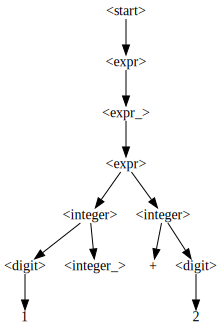

In [232]:
ll1parser = LL1Parser(A2_GRAMMAR)
tree = ll1parser.parse('1+2')
display_tree(tree)